# Kālī

Kālī is a software package written to model and study determinstic and stochastic astronomical light curves, i.e. ordered lists of flux as a function of time. Kālī provides two models for astronomical light curves: 
1. Continuous-time Autoregressive Moving Average (C-ARMA) processes (stochastic).
2. Massive Black Hole Binaries (MBHBs) with relativistic doppler beaming (deterministic).
3. Massive Black hole Binaries (MBHBs) with relativistic doppler beaming (stochastic, CARMA process).

## Concepts

CARMA processes are defined as solutions to the differential equation
$$\mathrm{d}^{p}x + \alpha_{1} \mathrm{d}^{p-1}x + \ldots + \alpha_{p-1} \mathrm{d}x + \alpha_{p}x = \beta_{0} (\mathrm{d}W) + \ldots + \beta_{q} \mathrm{d}^{q}(\mathrm{d}W).$$
Realize that this differential equation is just a vanilla linear differential equation that happens to be driven by a noise process. For example, for a CARMA(2,1) process, the defining differential equation is
$$\mathrm{d}^{2}x + \alpha_{1} \mathrm{d}x + \alpha_{2}x = \beta_{0} (\mathrm{d}W) + \beta_{1} \mathrm{d}^{1}(\mathrm{d}W),$$
which we can cast into slightly friendlier form by re-defining the coefficients on the LHS as
$$\mathrm{d}^{2}x + 2 \zeta \omega \mathrm{d}x + \omega^{2} x = \beta_{0} (\mathrm{d}W) + \beta_{1} \mathrm{d}^{1}(\mathrm{d}W).$$
Astute readers will notice that the LHS is just a damped harmonic oscillator making the whole equation that of a forced damped harmonic oscillator! The forcing term is a 'blue'-noise process.

Kālī consists of multiple Python sub-modules that call underlying c++ libraries using Cython. All the sub-modules are structured around two concepts: `lc` objects that represent light curves and `task` objects that take `lc` objects as inputs and perform useful work such as fitting light curves to various models, both stochastic and non-stochastic. The `lc` aobjects are abstract objects that must be inherited from to make concrete instantiable sub-classes such as the `mockLC`, `externalLC`, `sdssLC`, `k2LC` and the `crtsLC` objects. The abstract `lc` and the concrete `mockLC` & `externalLC` classes are defined in the `lc.py` file. The concrete `sdssLC`, `k2LC`, and `crtsLC` objects are all defined in thier respective `s82.py`, `k2.py`, and `crts.py` files.

The two concrete classes `mockLC` and `externalLC` are designed for slightly different purposes. `mockLC`s are to be used for simulated data generated by various `task` objects while `externalLC`s are to be used when performing one-off analysis of a real light curve. Typically, if multiple real light curves are to be studied with Kālī, it is better to define custom `lc` classes such as the `sdssLC` defined in `s82.py` and the `k2LC` defined in the `k2.py` files. A quick look at these files shows how the two classes deal in very different ways with getting SDSS and K2 light curves. The SDSS lightcurves are hosted on multiple author-run servers and the class uses `zeromq` to talk to these servers and fetch the required light curves from them. The K2 data are fetched from the NASA MAST servers where they are hosted on-demand. The idea is to let data-set specific sub-classes of `lc` specialize for the data-set being used and make the remaining package agnostic to the source of the data. Later on in this document, we will provide guidelines for creating inherited sub-classes of `lc`.

We shall begin by introducing the reader to the `CARMATask` object.

## `CARMATask`s and `mockLC`s

The `CARMATask` object allows us to perform C-ARMA analysis on light curves. In order to use a `CARMATask`, it is necessary to import the `carma` module. After this, we can create a new basic task object called `firstNewTask` to study the C-ARMA(2,1) model as follows:

In [1]:
import kali.carma
firstNewTask = kali.carma.CARMATask(2,1)

All `task` objects contain one or more models i.e. each task object is capable of being used to study multiple models simultaneously. The only restriction is that the models held by each task object have to have the order i.e. in the case of `CARMATask`s that are designed for C-ARMA models, all the C-ARMA models held by a single `CARMATask` have to have the the same `p` & `q` order. Of course, this does not prevent us from having multiple task objects declared at once. By default, the `task` object initializer will query your system to determine how many hardware threads (including Intel Hyperthreading) your CPU supports and will hold that number of models. However, this behavior can be changed by explicitly instructing the task constructor to create a specific number of models in the task as follows:

In [2]:
anotherNewTask = kali.carma.CARMATask(3, 1, nthreads = 2)

`anotherNewTask` is a `CARMATask` that holds two C-ARMA(3,1) models for use. In the case of `CARMATask`s, we can specify how models will burn in light curves when generating simulated light curves by initializing the `yetAnotherNewTask` object as follows:

In [3]:
yetAnotherNewTask = kali.carma.CARMATask(4, 2, nthreads = 1, nburn = 100000)

Here `yetAnotherNewTask` is a `CARMATask` that holds a single C-ARMA(4,2) model. Any simulated light curves generated by `yetAnotherNewTask` will automatically be burnt in for 100,000 steps. Other parameters that can be passed to the `CARMATask` constructor include `nwalkers`, `nsteps` etc... Please refer to the code documentation for the exact list of parameters accepted by the constructor. For the rest of this section, we will make a new `CARMATask` object `newTask` and set the number of steps taken by the MCMC walkers to 500 to properly sample our posterior space.

In [4]:
newTask = kali.carma.CARMATask(2, 1, nsteps = 500)

At this point, our `CARMATask` objects are hollow objects that lack numerical meaning. We must specify C-ARMA model parameters to be able to do useful things with our tasks. Two model parameters are required - a double precision value for the time-step `dt` to be used for simulations and a numpy ndarray of doubles `Theta` for the C-ARMA model coefficients. Mathematically, an individual C-ARMA model can be specified using either the co-efficients representation or the roots representation. The roots representation is much more convenient to use when providing model parametrs because it is trivial to pick valid values. However, Kālī requires that the C-ARMA model be specified purely in terms of the C-ARMA model coefficients and provides helper functions to convert the roots representation to the coeffiecients represenation. Let us set the first C-ARMA model in the `newTask` object to have an autocorrelation function that decays with two timescales - `107.8` d and `43.2` d. We shall set the MA timescale to be `5.5` d and set the amplitude of the light curve (i.e. the square root of the asymptotic autocorrelation function) to be 1.0

In [5]:
r_1 = (1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

Note that we have purposely made the first root positive i.e. the C-ARMA model corresponding to this set of roots will be unstable. We can use the helper function `kali.carma.coeffs(p, q, Rho)` to compute the polynomial coefficients representation corresponding to this roots representation as follows: 

In [6]:
import numpy as np
Rho = np.array([r_1, r_2, m_1, amp])
Theta = kali.carma.coeffs(2, 1, Rho)
print Theta

[  2.08440441e-02  -2.79410779e-04   1.81818182e-01   1.00000000e+00]


We can check the returned `Theta` for validity using the `check(Theta)` method of the `CARMATask` object `newTask` as follows:

In [7]:
print newTask.check(Theta)

False


After fixing the bad root, we can rerun the check as follows

In [8]:
r_1 = (-1.0/107.8) + 0j
Rho = np.require(np.array([r_1, r_2, m_1, amp]), requirements=['F', 'A', 'W', 'O', 'E'])
Theta = kali.carma.coeffs(2, 1, Rho)
print Theta
print newTask.check(Theta)

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


Note that we wrapped the definition of Rho in a `np.require` call that ensures that the underlying data in `Rho` is contiguous in memory and can thus be accesses by simple pointer arithmetic in the underlying `c++` library. Although it is not necesary to wrap such small arrays in the `np.require` call, it is good practice and can help avoid mysterious memeory related errors as well as silent garbage output caused by an incorrect interpretation of a pointer as data. 

After having established that we have a good C-ARMA model coefficients vector, let us set the first C-ARMA model in `newTask` to use this vector. We also pick the time increment `dt` between points in the light curve to be `dt = 0.1` d. We can set the first C-ARMA model held by `newTask` to the specified `dt` and `Theta` as follows:

In [9]:
dt = 0.1
newTask.set(dt, Theta, tnum = 0)

0

The return value of `0` indicates that the method call completed without error. We can check to see which of the C-ARMA models held by `newTask` has been set as follows:

In [10]:
newTask.list()

array([ True, False, False, False, False, False, False, False], dtype=bool)

As can be seen above, only the first model has been set with values so far. We can see the resulting values of the C-ARMA model matrices as follows:

In [11]:
newTask.show()

As can be seen by the way we issued the two previous commands, we do not have to specify `tnum = 0` because the default for `tnum` is `0` i.e. the first C-ARMA model held by the task. `tnum` was not required for the call to `set(dt, Theta)` either. Having set the model, we can also obtain the asymptotic standard deviation of light curves made with this model, i.e. the variability of the light curve, as follows:

In [12]:
import math
math.sqrt(newTask.Sigma()[0,0])

1.0000000000000002

It turns out that the variability amplitude is `1.0` flux units which should come as no surprise given that we picked `amp` in the roots representation `Rho` to be `1.0` to begin with. We can plot the power spectral density of the C-ARMA as follows:

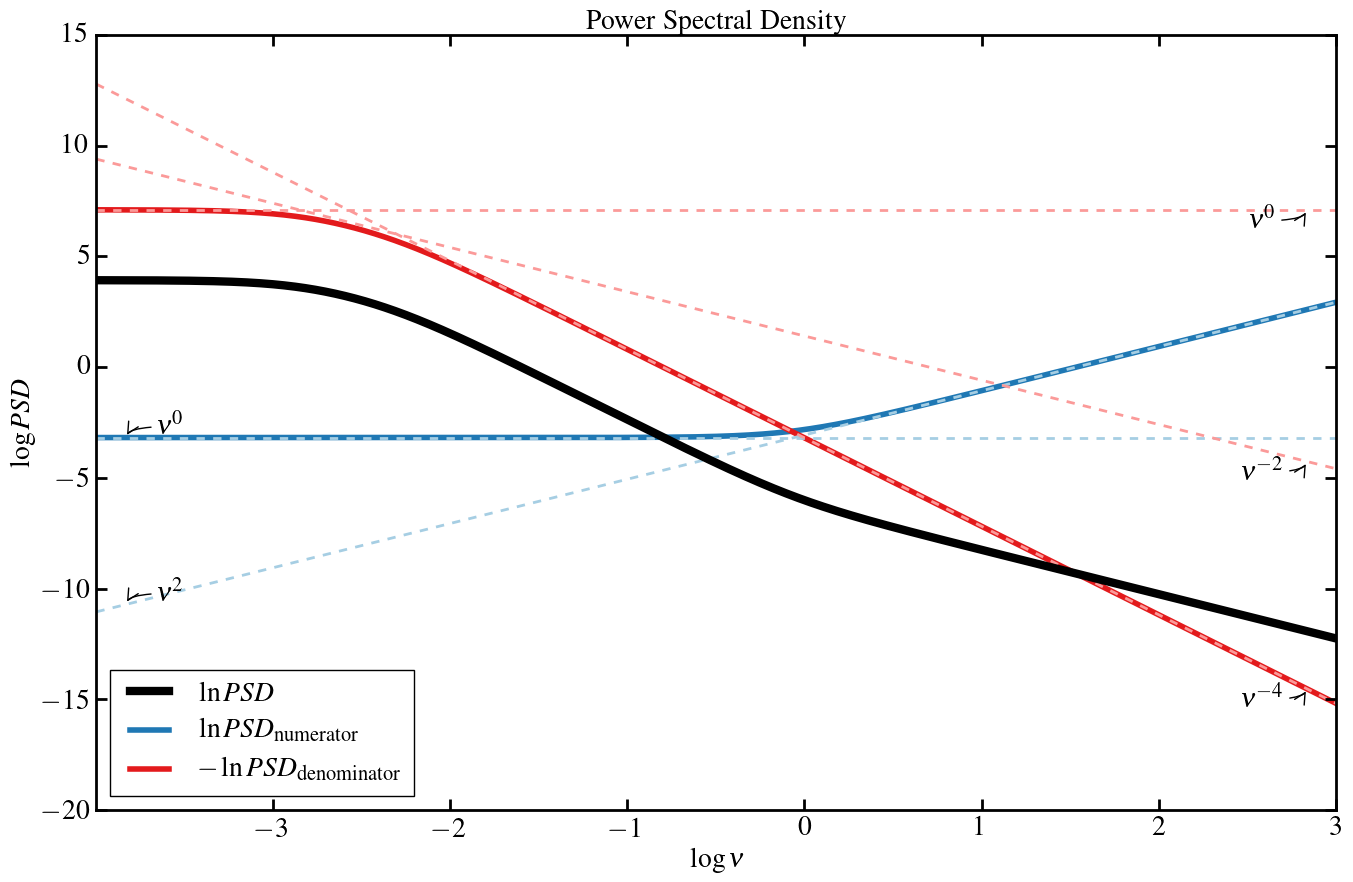

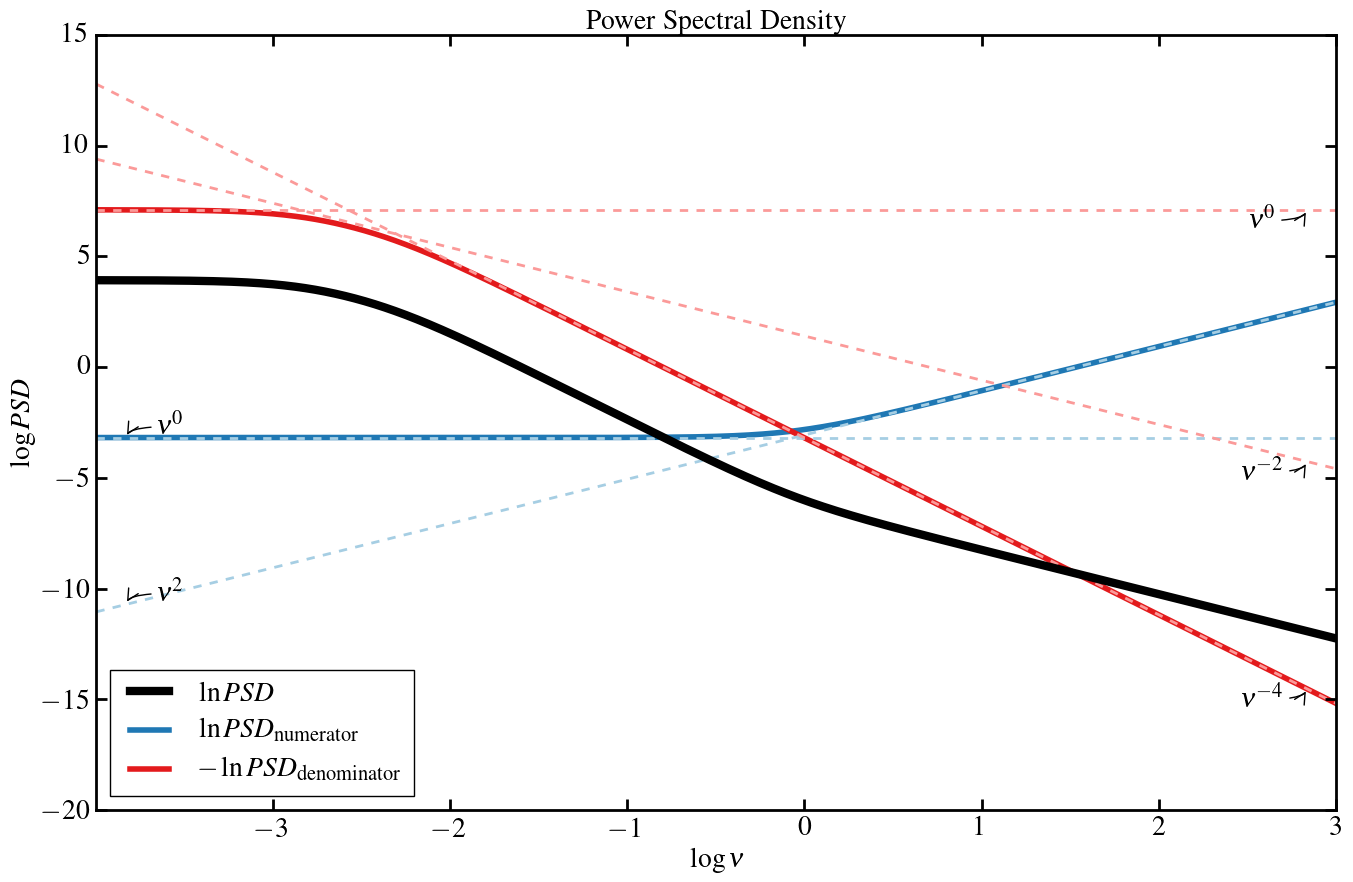

In [13]:
newTask.plotpsd(doShow = False)

The black line above is the final PSD. It is the sum of the red (log PSD numerator) and blue (-log PSD denominator) lines. They in turn are generated by evaluating the respective numerator and denominator polynomial functions of frequency at each frequency. Consider the numerator polynomial (blue) first. At low frequencies, i.e. on long timescales, it is completely dominated by the freq^0 term. At a frequency of about 1/day, the freq^2 term begins to dominate. The same way, in the case of the denominator, the chosen coefficients lead to the freq^0 term dominating on long timescales. On shorter timescales, the freq^2 term would have begun to dominate, except that the freq^4 term becomes important just a little later. So the PSD is dominated by the freq^2 denominator term over a very small range of timescales and we should expect to find that model parameter recovery will be hard (i.e. we won't do a good job unless our light curve is very long). The overall PSD does show a flattening of the slope at high frequencies, but this is driven purtely by the numerator freq^2 term.
At this point, we are ready to simulate a light curve using this C-ARMA model. The `simulate(T)` method of `CARMATask` requires the duration of the desired light curve and returns a `mockLC` object. We can create a new light curve of length `1000` d as follows:

In [14]:
newLC = newTask.simulate(duration=1000.0)

This creates a new lightcurve object of class `mockLC` that has been regularly sampled with sampling interval `dt` and of duration `1000` d. Alternatively, we could have obtained a `mockLC` with irregular sampling by passing in a numpy array or python list `tIn` of timestamps. Obviously, we cannot pas in both `duration` and `tIn` at the same time. Having made a mock light curve, we can view the simulated light curve `newLC` using the `plot()` method that all `lc` objects support as follows:

/home/vish/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


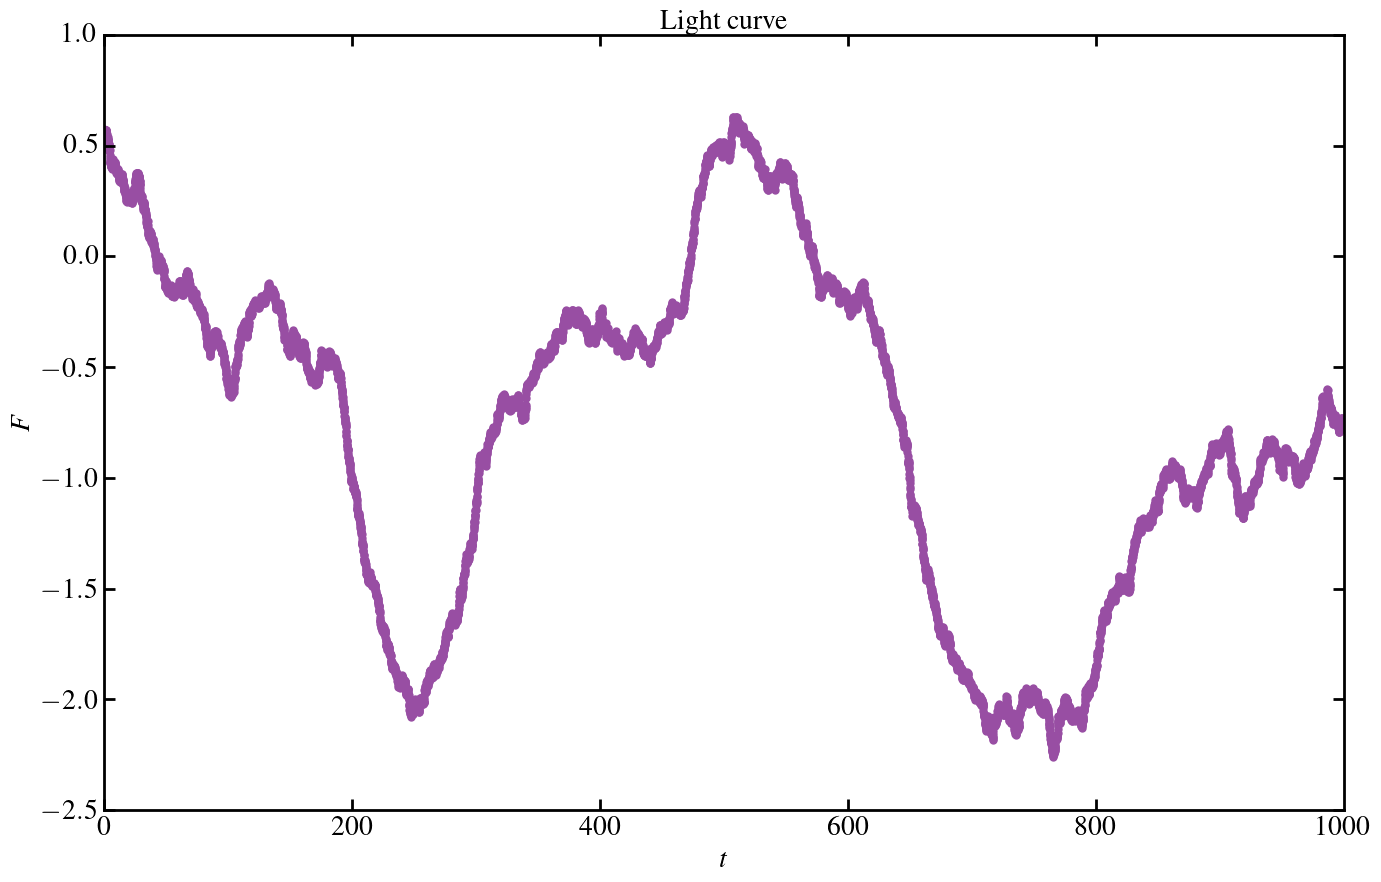

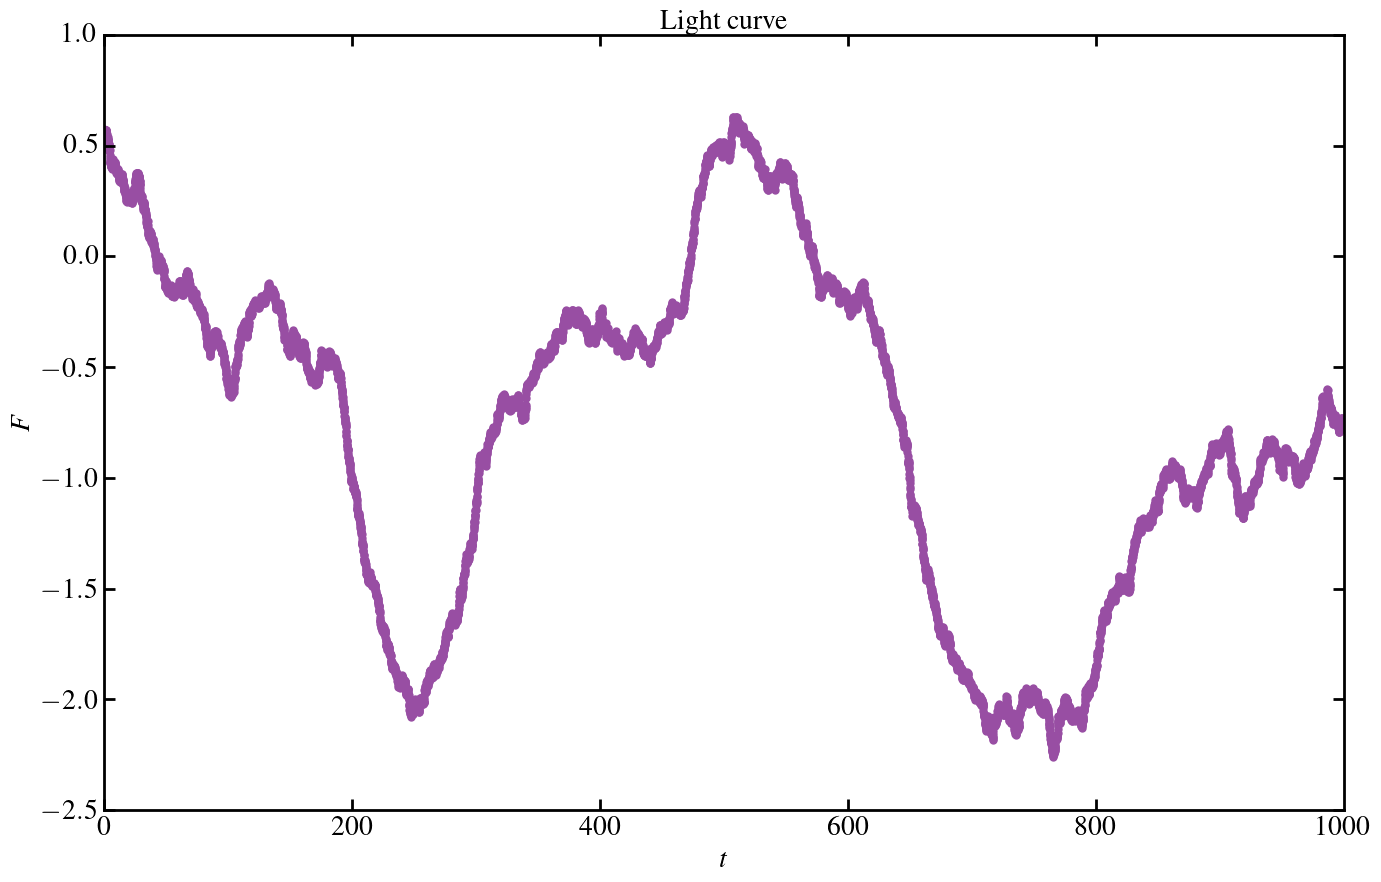

In [15]:
newLC.plot()

This light curve has no noise. We can simulate noise by fixing two parameters - the fractional level of variability (fracIntrinsicVar = 0.15 by default) and the fractional level of the noise to the signal (fracNoiseToSignal = 0.001 by default). Once we have fixed these two parameters, we can simulate noise as follows:

In [16]:
newTask.observe(newLC)

Once again, we can plot the resulting light curve using the `plot()` method of all `lc` objects as follows:

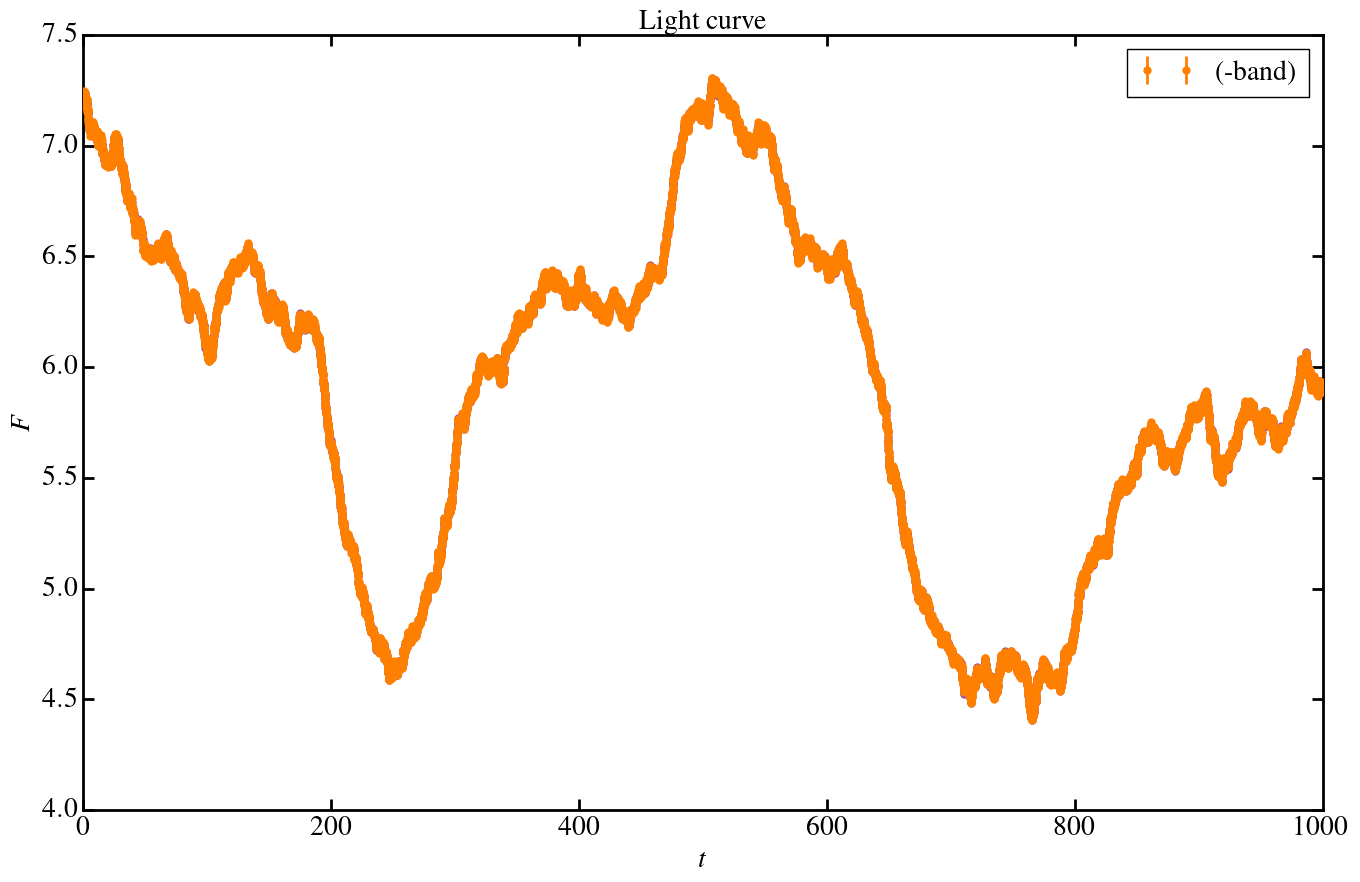

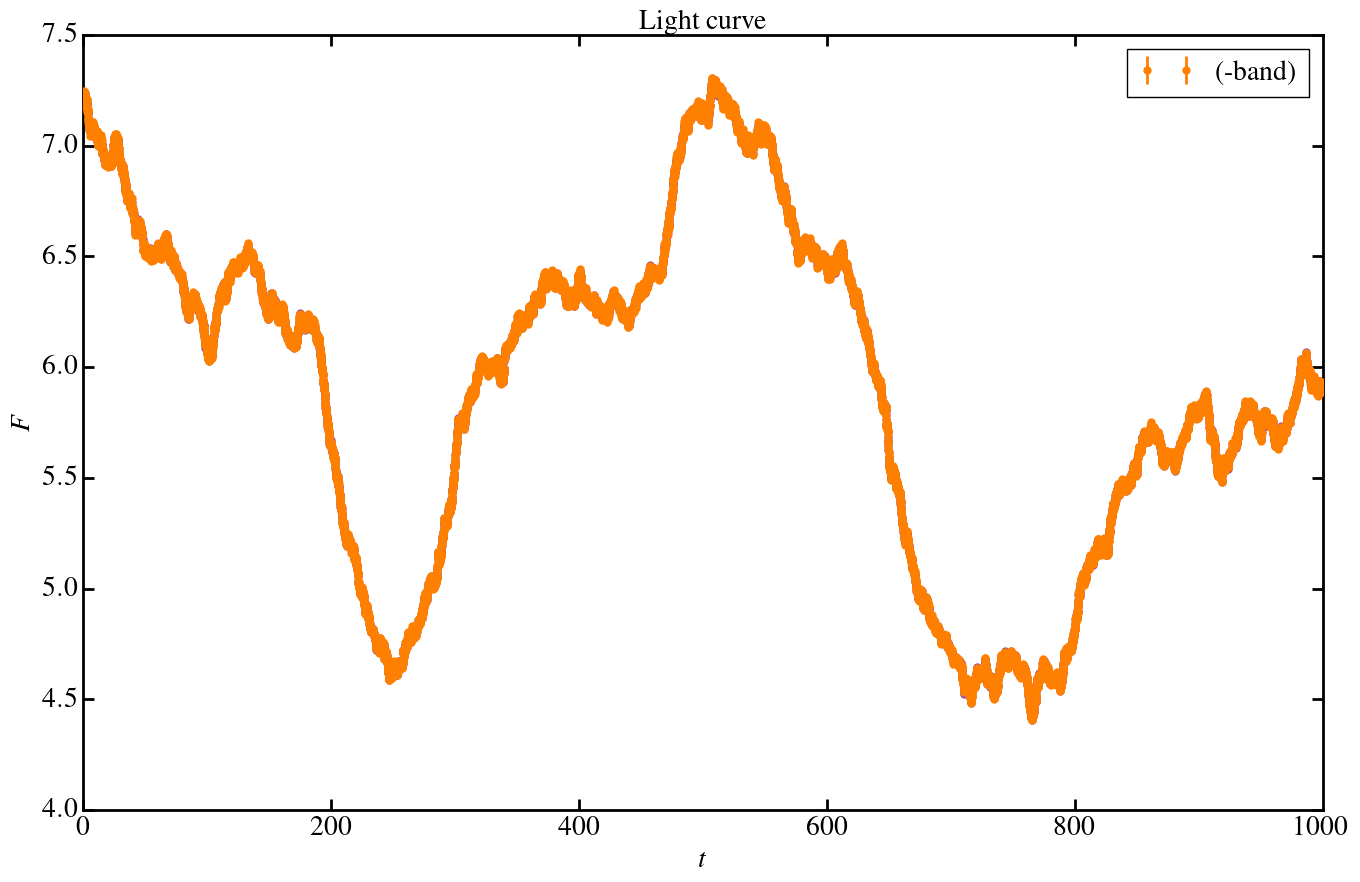

In [17]:
newLC.plot()

Lets change the noise-to-signal ratio and re-observe the light curve.

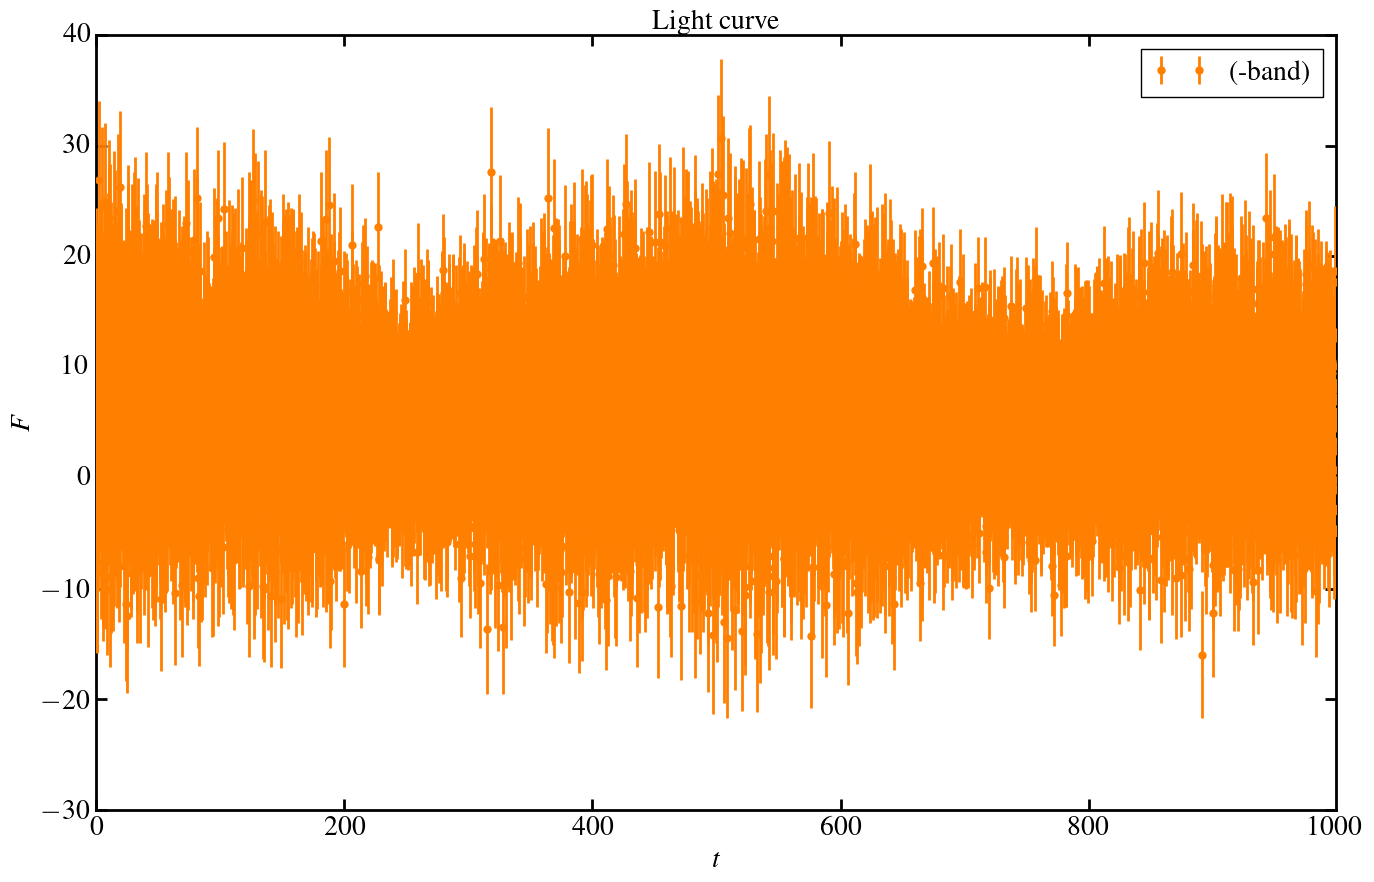

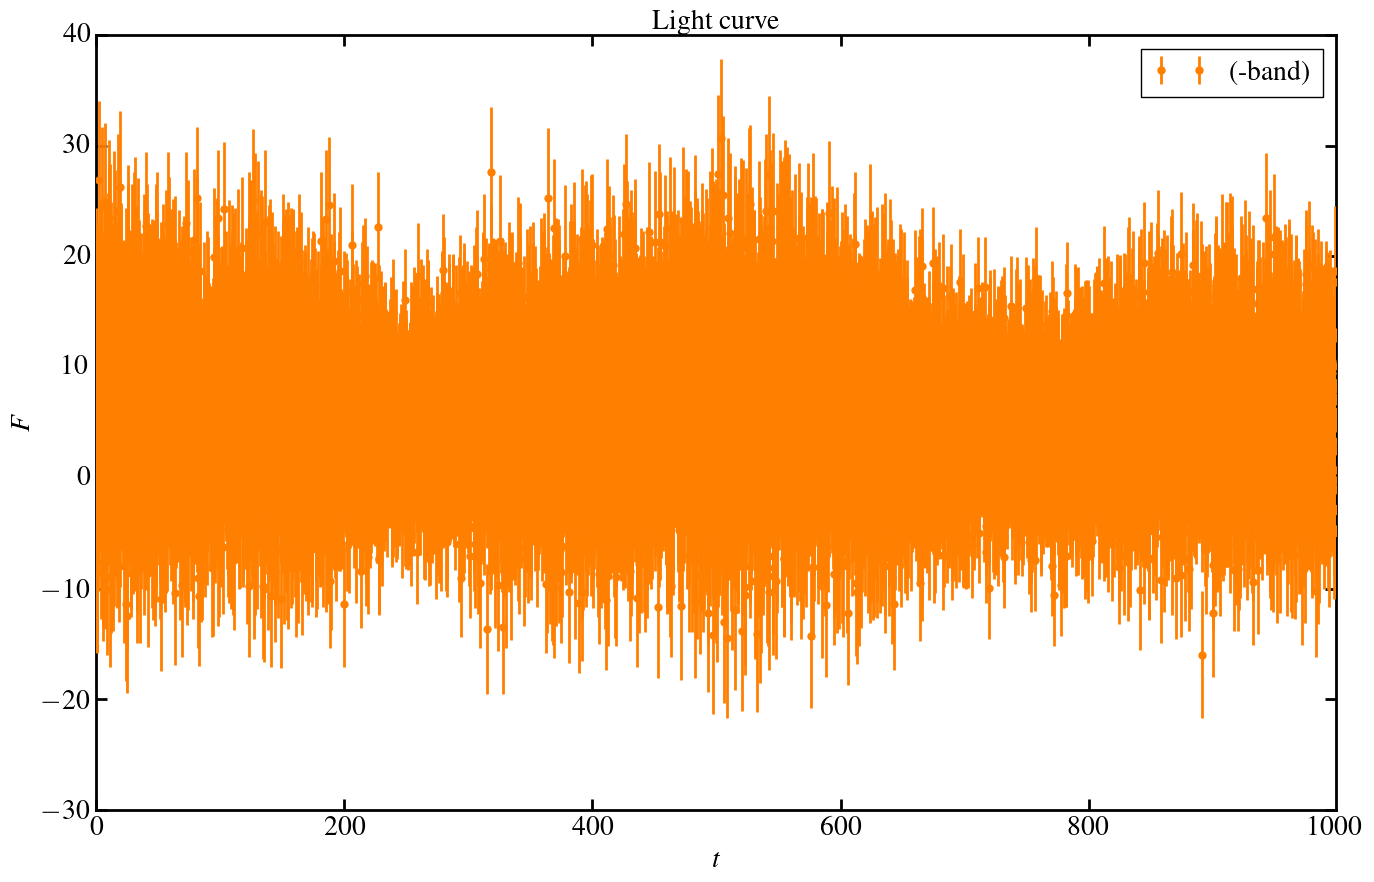

In [19]:
newLC.fracNoiseToSignal = 1.0
newTask.observe(newLC)
newLC.plot()

Before proceeding further, let's drop the noise to signal back down to a realistic level (~ 0.1% photometry).

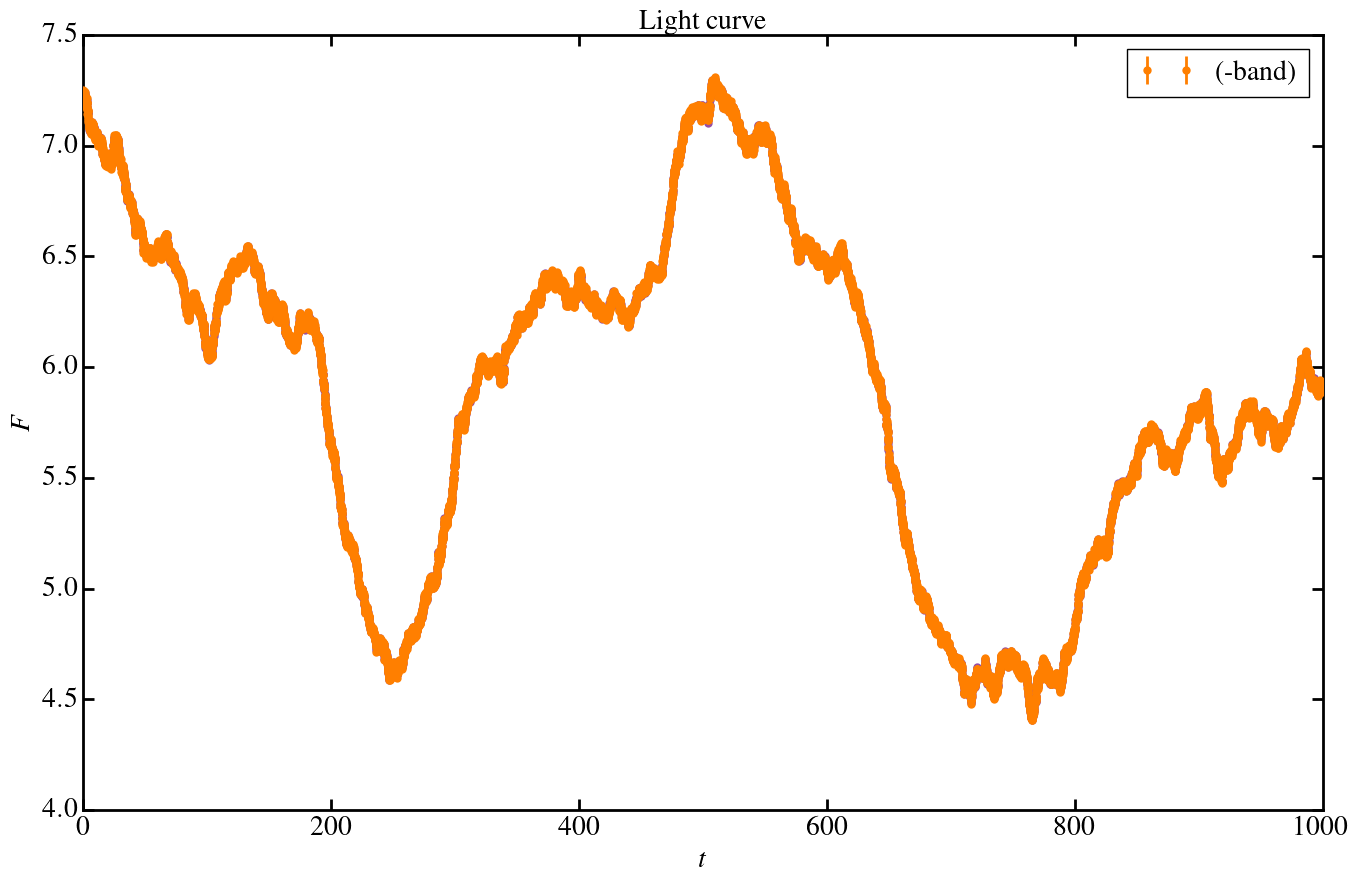

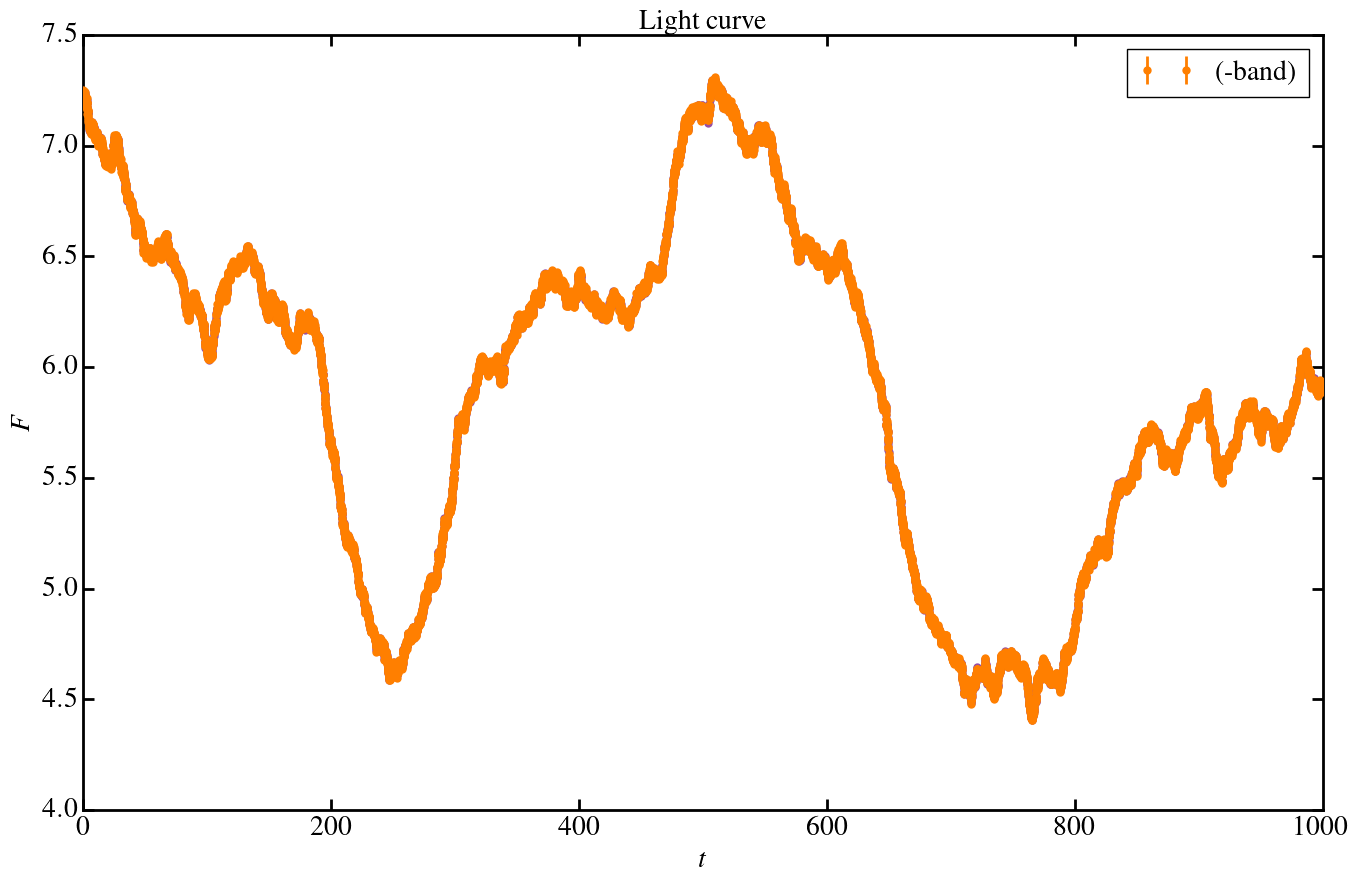

In [21]:
newLC.fracNoiseToSignal = 0.001
newTask.observe(newLC)
newLC.plot()

Lets look at the periodogram of this mock light curve.

/home/vish/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


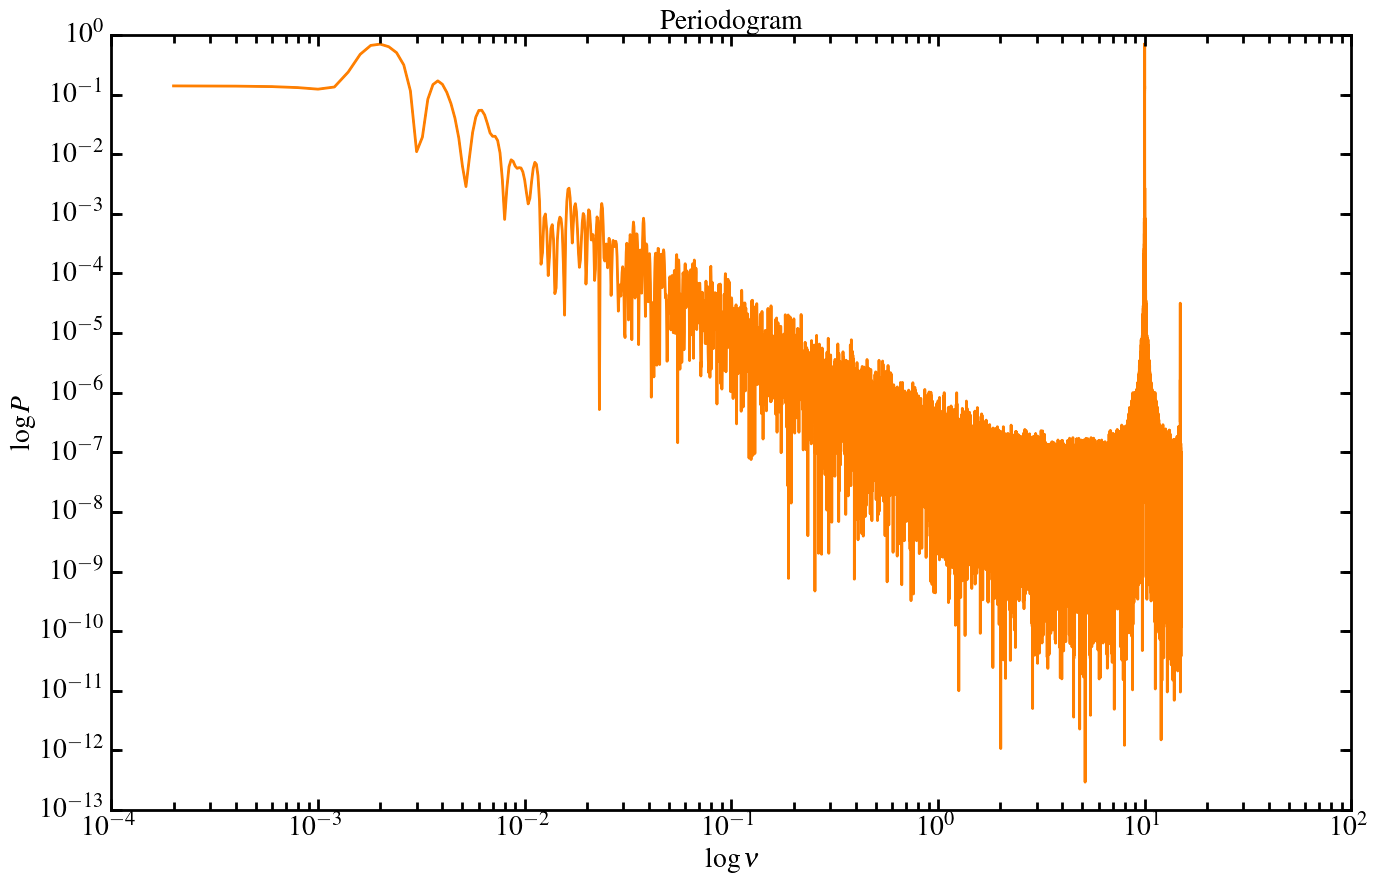

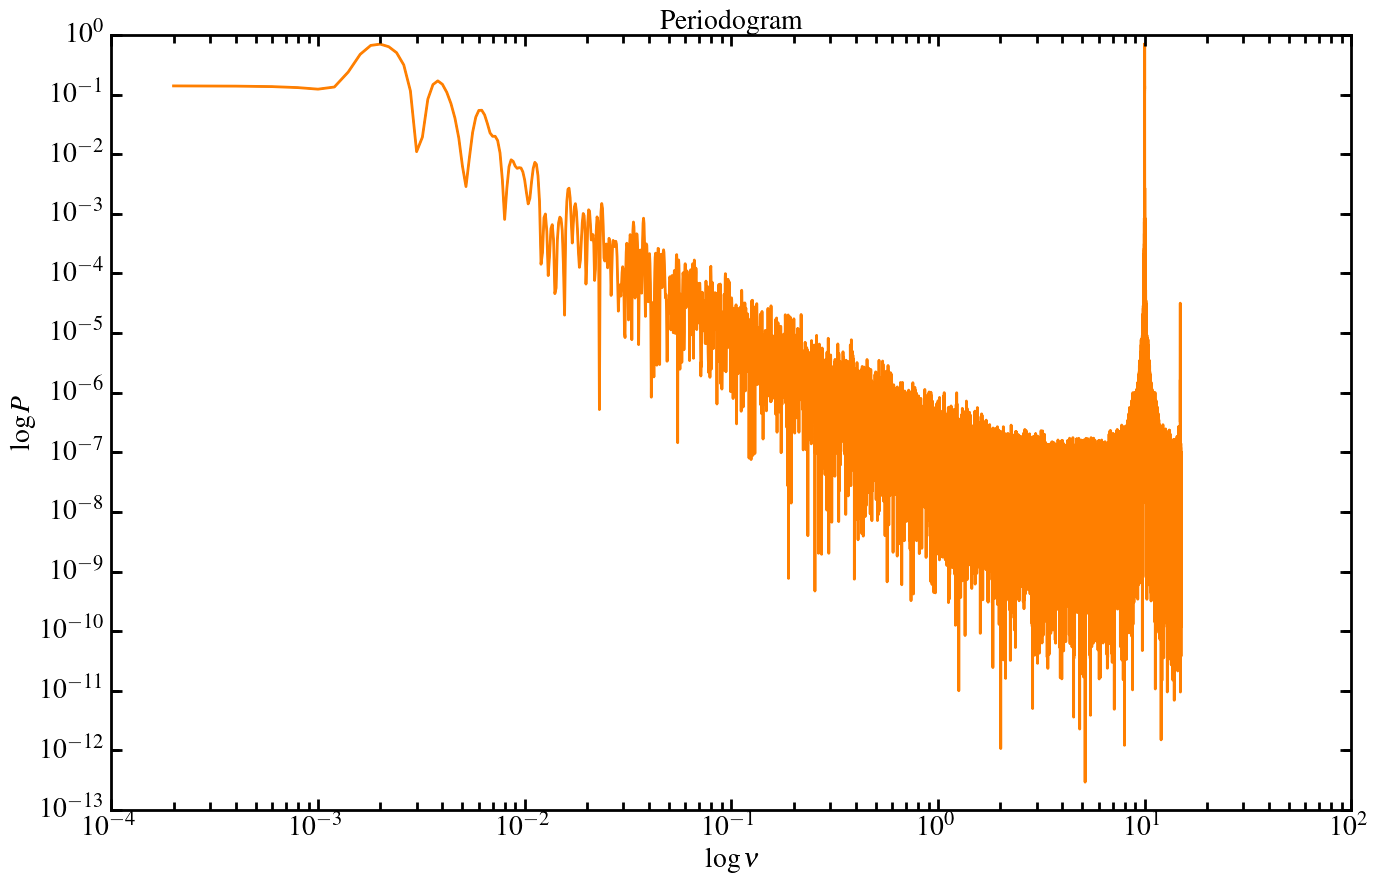

In [22]:
newLC.plotperiodogram()

How well does thsi match up with the psd of the task object that we used to create the light curve in the first place?

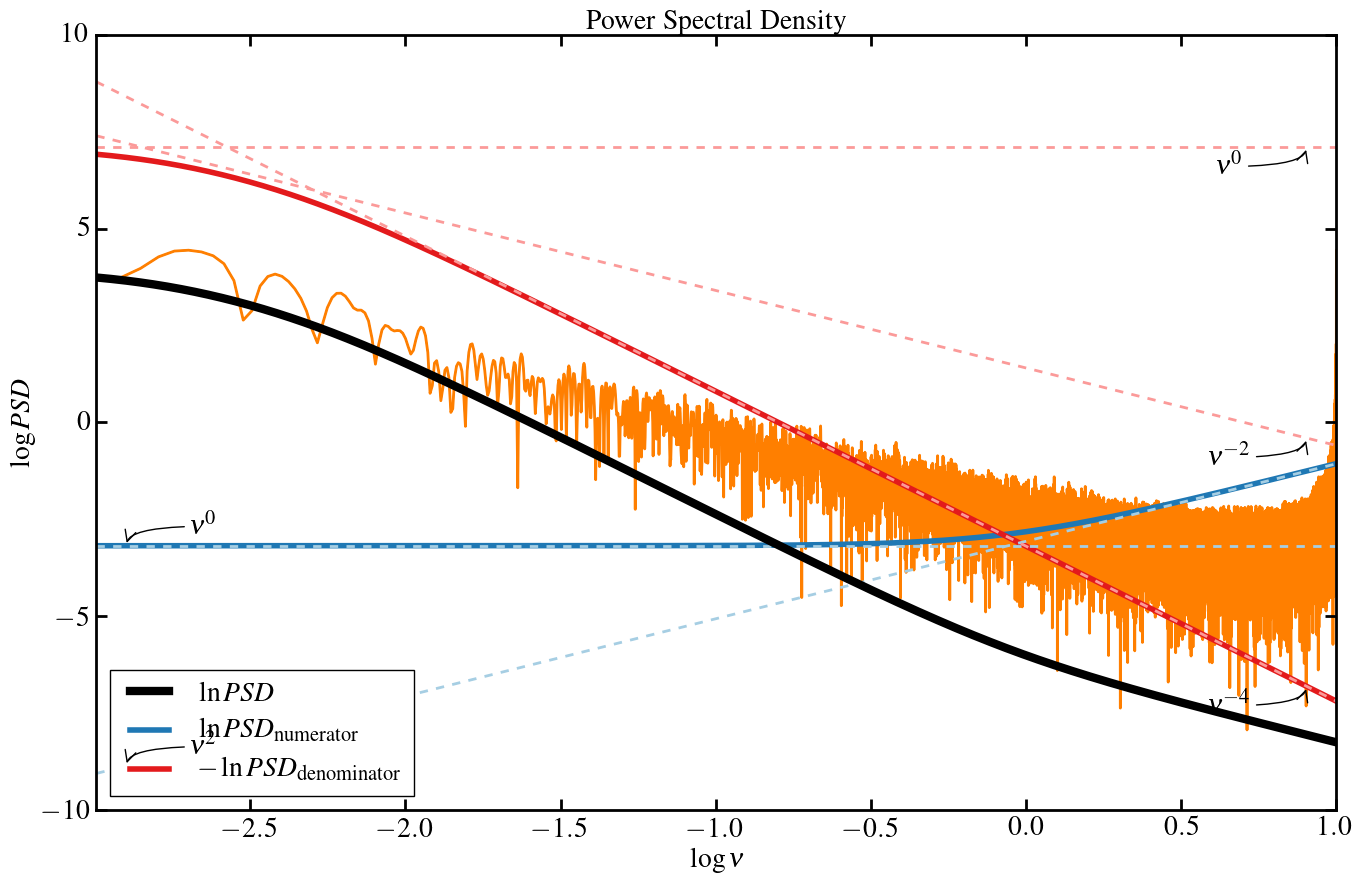

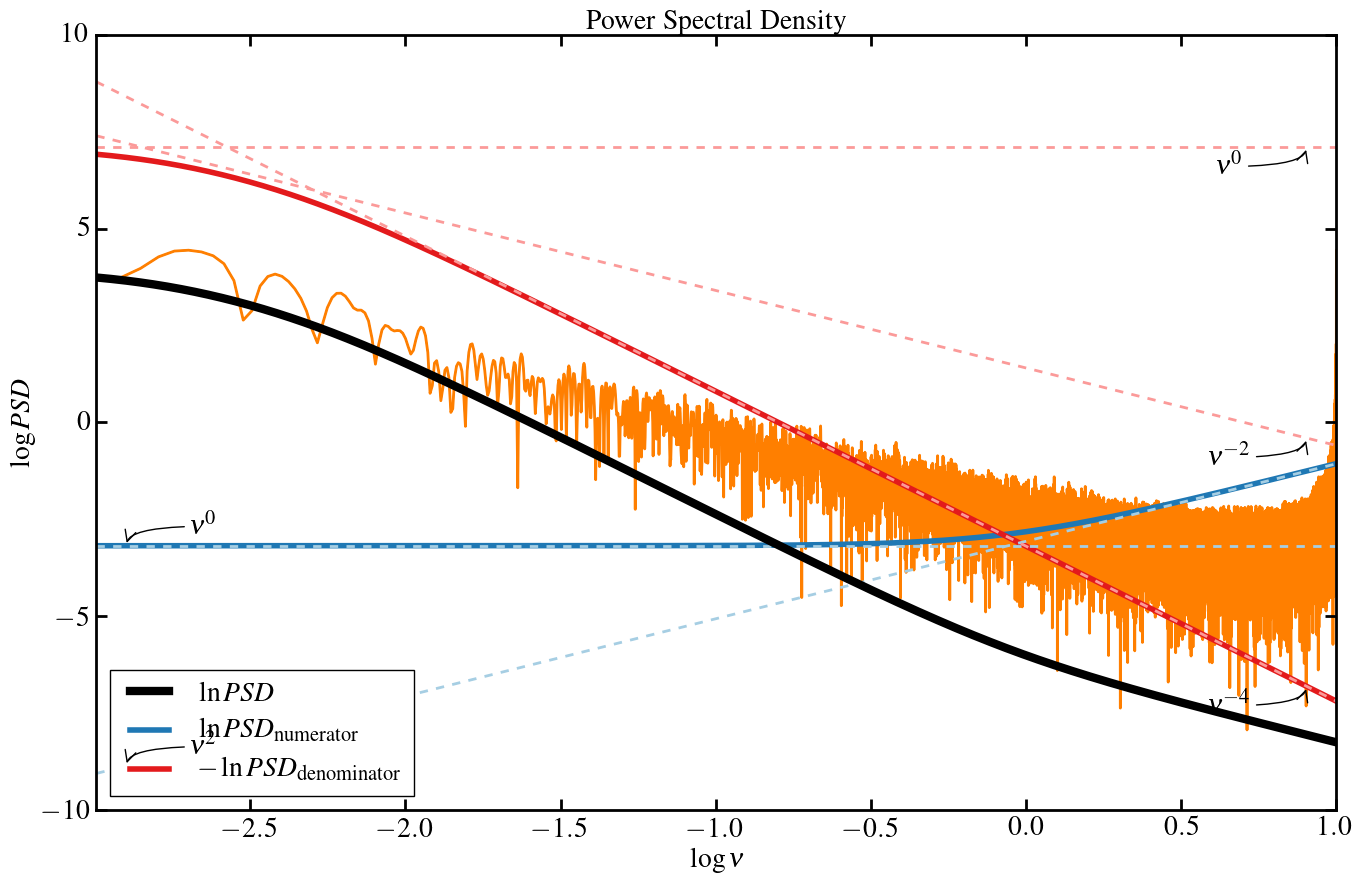

In [23]:
newTask.plotpsd(LC=newLC)

As can be seen above, pretty well! The two match at low frequencies (note that we re-normalize the periodogram of the light curve in the process of generating this plot). At high frequencies, the two diverge some because of the observation noise, with the observed light curve periodogram flattening at the observation noise level.

Consider the effect of the noise. A high order C-ARMA(p,q) model with large p but small q tends to be fairly smooth. Gaussian white noise can potentially make the light curve look less smooth than it actually is! We can compute the log likelihood of this light curve under the same C-ARMA model that it was computed using as follows: 

In [24]:
print newTask.logLikelihood(newLC)

30578.1848725


In a Bayesian context, we can assign a prior to the C-ARMA parameter values based on factors such as the length of the light curve and the median/mean seperation between observations etc... For example, C-ARMA model parameters with inbuilt timescales that are of significantly longer duration than the length of the observed light curve must be treated with suspicion. Note that we have to be very careful here with how we think about this. It is entirely possible to observe a light curve for too short a duration - that is a failing of the observations. In such cases, it is impossible for us to get an accurate estimate of the true timescale from such observations. But if the algorithm suggests that the actual timescale is many times longer than the duration of our observations, we must treat the result with suspicion. We can compute the log pior probability of a model given a light curve as follows:

In [25]:
print newTask.logPrior(newLC)

0.0


Since this light curve is a litte over twice as long as the longest in-built timescale (about 65 days), and since the predicted variance of the light curve matches well with the variance of the light curve, etc..., the log prior is 0.0 indicating that the model is acceptable. Given the likelihood and the prior, we can compute the posterior probability using simple addition:

In [26]:
print newTask.logPosterior(newLC)

30578.1848725


How do we control the prior? The lightcurve object has three variables that are CRITICAL! - the maxSigma, the minTimescale, and the maxTimescale. The default values are conservative - maxSigma = 2.0, minTimescale  = 2.0 and maxTimescale = 0.5. How are these values used? If the sqrt(Sigma[0,0]) i.e. the theoretical asymptotic variance of the light curve is greater than maxSigma time the standard devaition of the observed light curve, we set the prior to 0 i.e the logPrior to -infinity. If any timescale corresponding to the AR coefficients is greater than maxTimescale times the duration of the observed light curve or if it is shorter than minTimescale time the smallest timestep, we set the prior to 0. This way, we can insist on the code returning sane results. If the light curve is very short, it may be helpful to turn maxSigma and maxTimescale up a bit. If the light curve is very poorly sampled, it may help to turn minTimescale down. However, loosening the priors too much can result in spurious peaks of the likelihood space being returned as optimal. Generally speaking, it is better to err on the tighter side until we have more experience with C-ARMA modelling. That being said, it is time to try fitting this light curve with a model.
Fitting the lightcurve to a CARMA model can be done via the `fit` method of any of our `basicTask` objects. We shall use the `newTask` object that we had created earlier.

In [27]:
newTask.fit(newLC)

0

This computes a set of MCMC chains for the model parameter that are stored in the `Chain` attribute of the `newTask` object. The `Chain` attribute is just a numpy ndarray structured to be of the fornat `Chain[dimNum, walkerNum, stepNum]` and can be accessed accordingly. The log posterior for each walker and step is stored in another numpy ndarray attribute `LnPosterior` which is structered as `LnPosterior[walkerNum, stepNum]`. We can check how accurately we've recovered our original model by comparing the median of the `Chain` for a given dimension against the original value.

In [28]:
print 'Median of Chain: %+e; Original Theta: %+e'%(np.median(newTask.Chain[0,:,250:]), Theta[0])

Median of Chain: +5.233777e-02; Original Theta: +3.939692e-02


Of course, it far more intuitive to compare the input timescales directly. These are computed at first access in the `basicTask` attribute `timescaleChain` which is laid out exactly the same as the `Chain` attribute i.e. `timescaleChain[dimNum, walkerNum, stepNum]`. 

In [29]:
print 'Median of timescaleChain[1]: %+e; Original -1.0/Rho[0]: %+e'%(np.median(newTask.timescaleChain[1,:,250:]), -1.0/Rho[0])
print 'Median of timescaleChain[0]: %+e; Original -1.0/Rho[1]: %+e'%(np.median(newTask.timescaleChain[0,:,250:]), -1.0/Rho[1])
print 'Median of timescaleChain[2]: %+e; Original -1.0/Rho[2]: %+e'%(np.median(newTask.timescaleChain[2,:,250:]), -1.0/Rho[2])
print 'Median of timescaleChain[3]: %+e; Original Rho[3]: %+e'%(np.median(newTask.timescaleChain[3,:,250:]), Rho[3])

Median of timescaleChain[1]: +1.379722e+02; Original -1.0/Rho[0]: +1.078000e+02
Median of timescaleChain[0]: +2.322138e+01; Original -1.0/Rho[1]: +3.320000e+01
Median of timescaleChain[2]: +5.187771e+00; Original -1.0/Rho[2]: +5.500000e+00
Median of timescaleChain[3]: +7.984311e-01; Original Rho[3]: +1.000000e+00


/home/vish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/vish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/home/vish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/home/vish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


Notice how we have to compare `timescaleChain[1,:,:]` against `-1.0/Rho[0]` and `timescaleChain[0,:,:]` against `-1.0/Rho[1]`. This is because the contents of `timescaleChain` are always ordered in ascending order within the C-AR and C-MA timescale groups. We could have ordered the original timescales the same way but chose to order them differently to illustrate how the output `timescaleChain` timescales get ordered. Incidentally, if our model had complex roots, the `timescaleChain` array would contain an entry each for the timescales corresponsding to the real and compplex parts of the roots i.e. there would be minimal duplication. 
The `basicTask` object is also able to compute the attribute `rootChain` which holds the actual complex valued roots of the C-AR and C-MA polynomials and is laid out just like the `Chain` and `timescaleChain` attributes.
We can visualize the walkers as shown below. Notice how the walkers converge after ~ the first 100 steps or so. Such plots can be very useful diagnostics of how well burnt in the MCMC chains are.

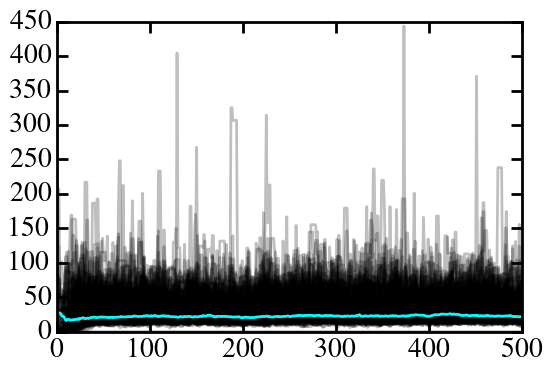

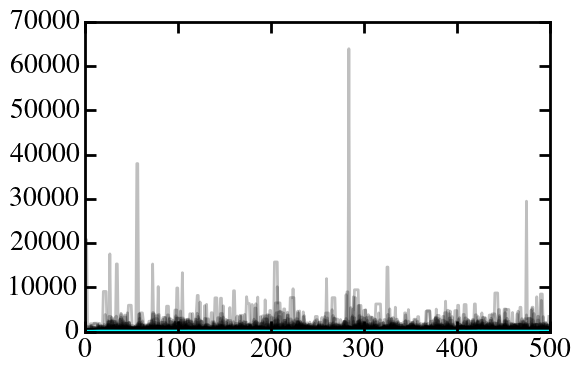

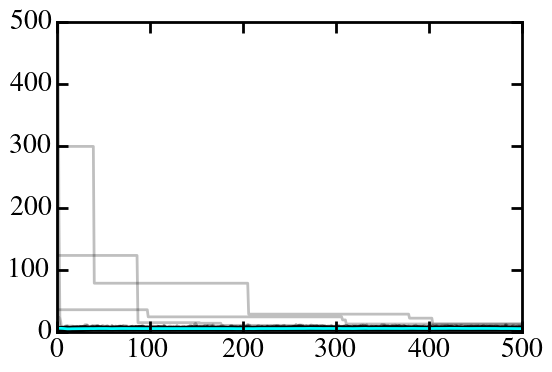

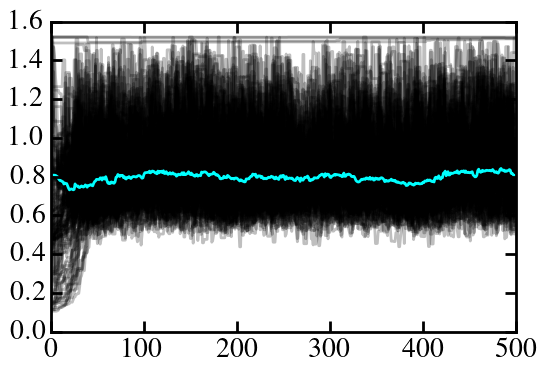

In [31]:
import matplotlib.pyplot as plt
plt.figure()
for i in xrange(200):
    plt.plot(newTask.timescaleChain[0,i,:], c = '#000000', alpha = 0.25)
plt.plot(np.median(newTask.timescaleChain[0,:,],axis = 0), c = '#00ffff')
plt.savefig('TAR0.jpg')
plt.figure()
for i in xrange(200):
    plt.plot(newTask.timescaleChain[1,i,:], c = '#000000', alpha = 0.25)
plt.plot(np.median(newTask.timescaleChain[1,:,],axis = 0), c = '#00ffff')
plt.savefig('TAR1.jpg')
plt.figure()
for i in xrange(200):
    plt.plot(newTask.timescaleChain[2,i,:], c = '#000000', alpha = 0.25)
plt.plot(np.median(newTask.timescaleChain[2,:,],axis = 0), c = '#00ffff')
plt.savefig('TMA0.jpg')
plt.figure()
for i in xrange(200):
    plt.plot(newTask.timescaleChain[3,i,:], c = '#000000', alpha = 0.25)
plt.plot(np.median(newTask.timescaleChain[3,:,],axis = 0), c = '#00ffff')
plt.savefig('AMP.jpg')
plt.show()

We can also easily grab the best fit C-ARMA(2,1) model parameters (and compare to the original input values) as follows

In [35]:
print newTask.bestTheta
print Theta

print newTask.bestRho
print Rho

print newTask.bestTau
print np.array([-1.0/Rho[1], -1.0/Rho[0], -1.0/Rho[2], Rho[3]])

[ 0.04641509  0.00036357  0.00466881  0.02586641]
[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
[-0.03643720+0.j -0.00997789+0.j -0.18049702+0.j  0.80812698+0.j]
[-0.00927644+0.j -0.03012048+0.j -0.18181818+0.j  1.00000000+0.j]
[  27.44447632  100.22161169    5.54025767    0.80812698]
[  33.2-0.j  107.8-0.j    5.5-0.j    1.0+0.j]


Let's set our task object to the best fit model parameters

In [37]:
newTask.set(dt, newTask.bestTheta)

0

We can plot the psd of the best-fit model (i.e. the analytic form) and the periodogram computed from the mock light curve as follows:

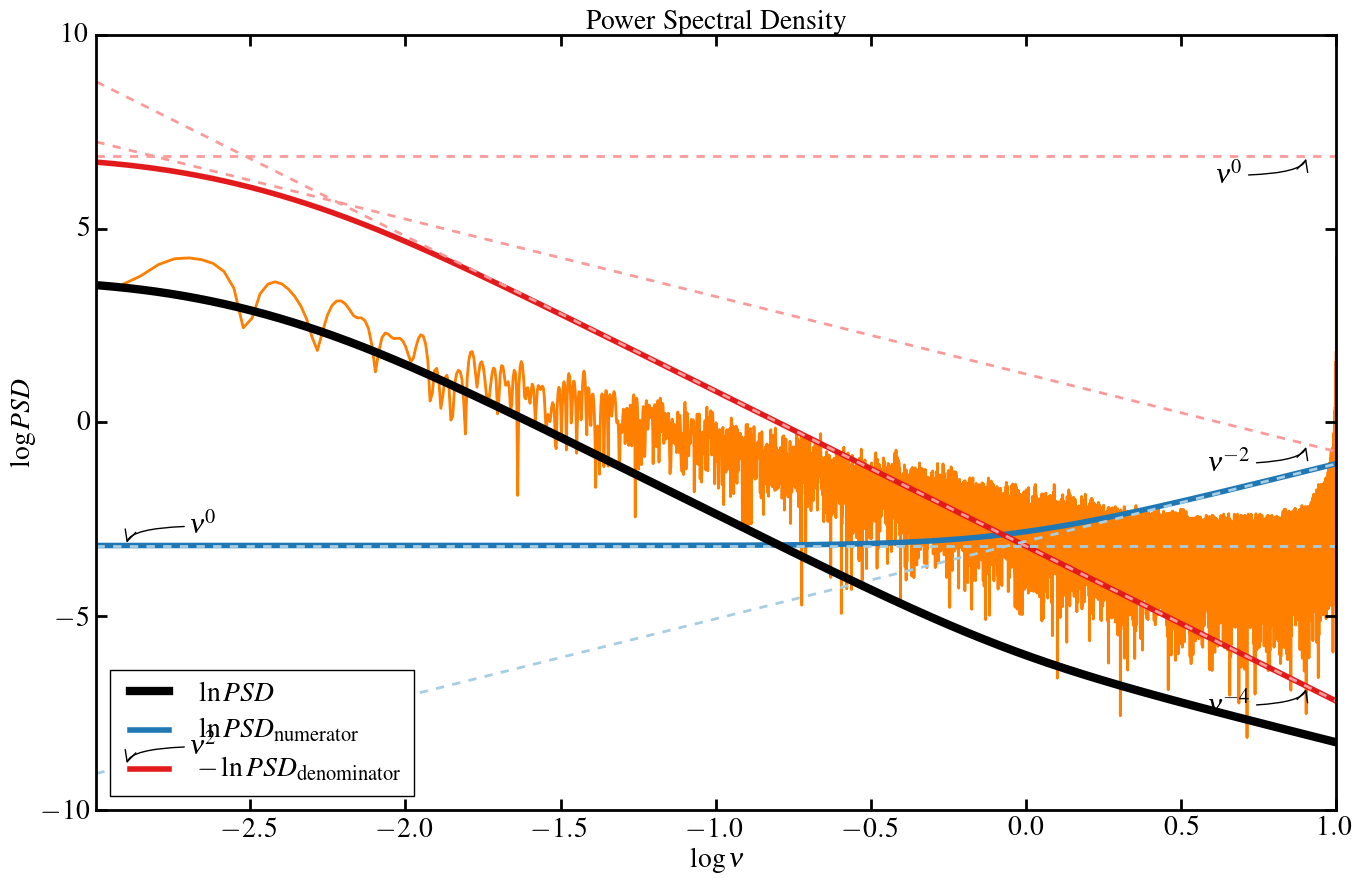

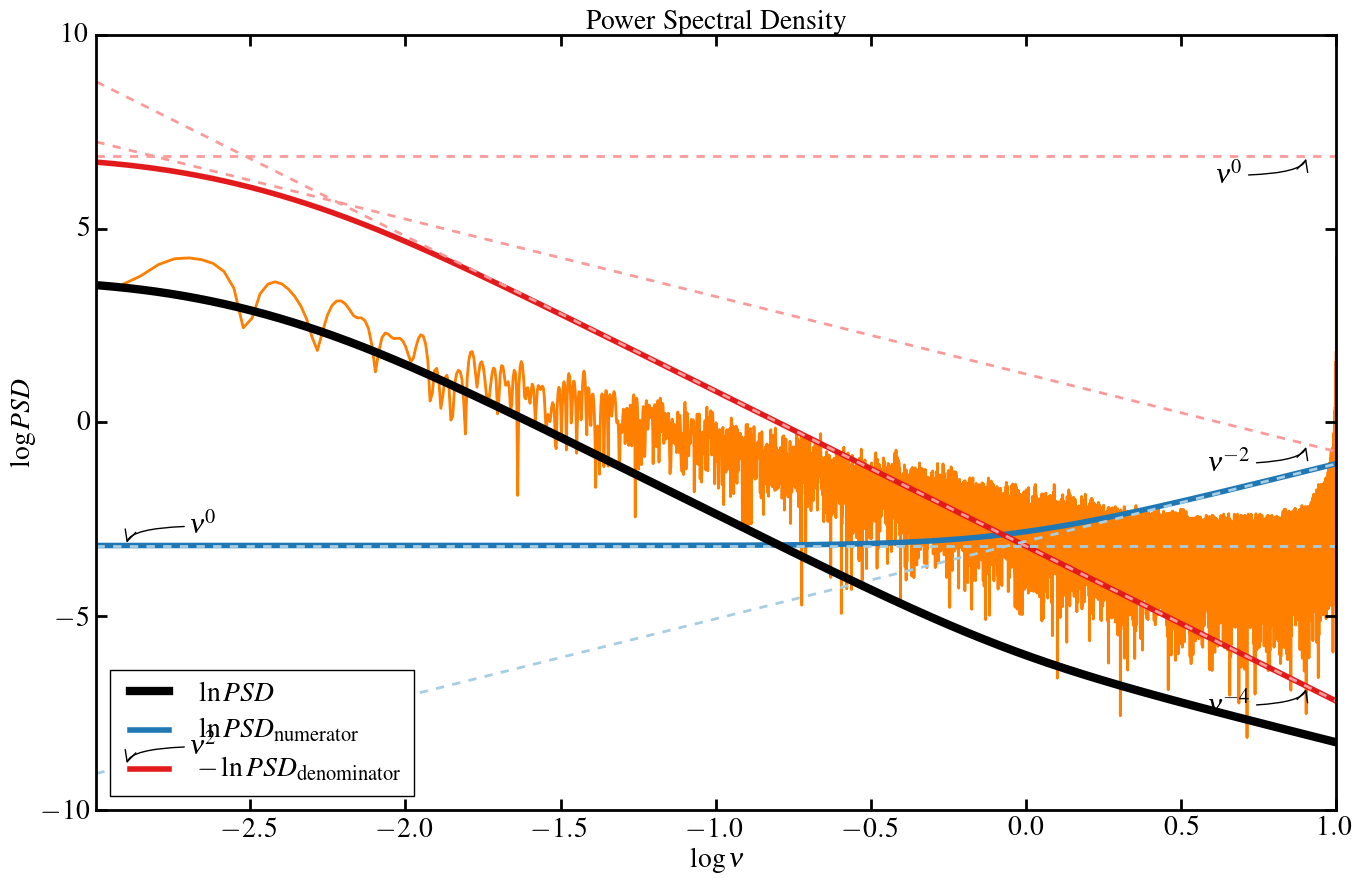

In [38]:
newTask.plotpsd(LC=newLC, doShow=False)

We can also plot the structure function of the best-fit model (i.e. the analytic form) and the structure function computed from the mock light curve as follows:

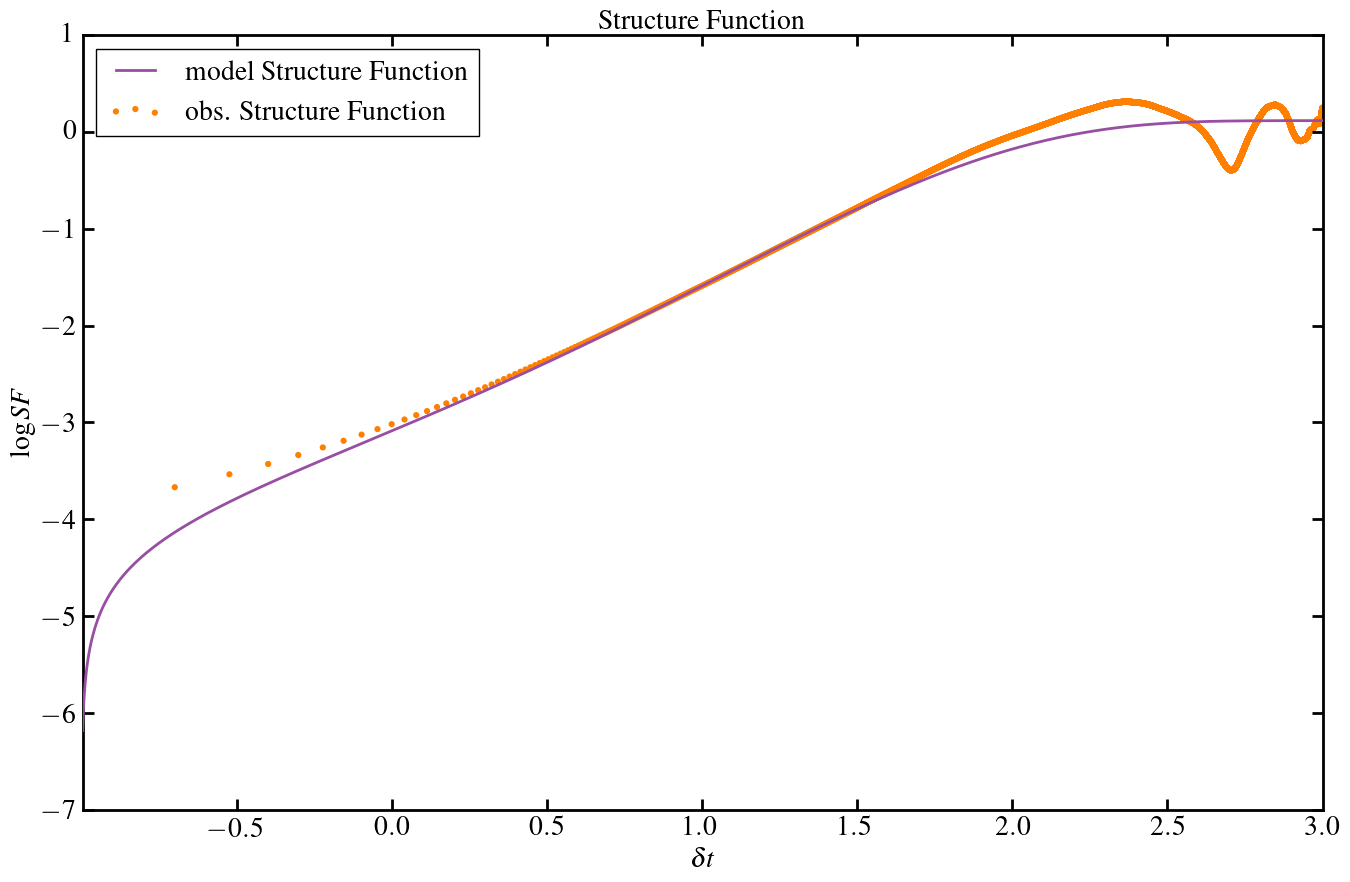

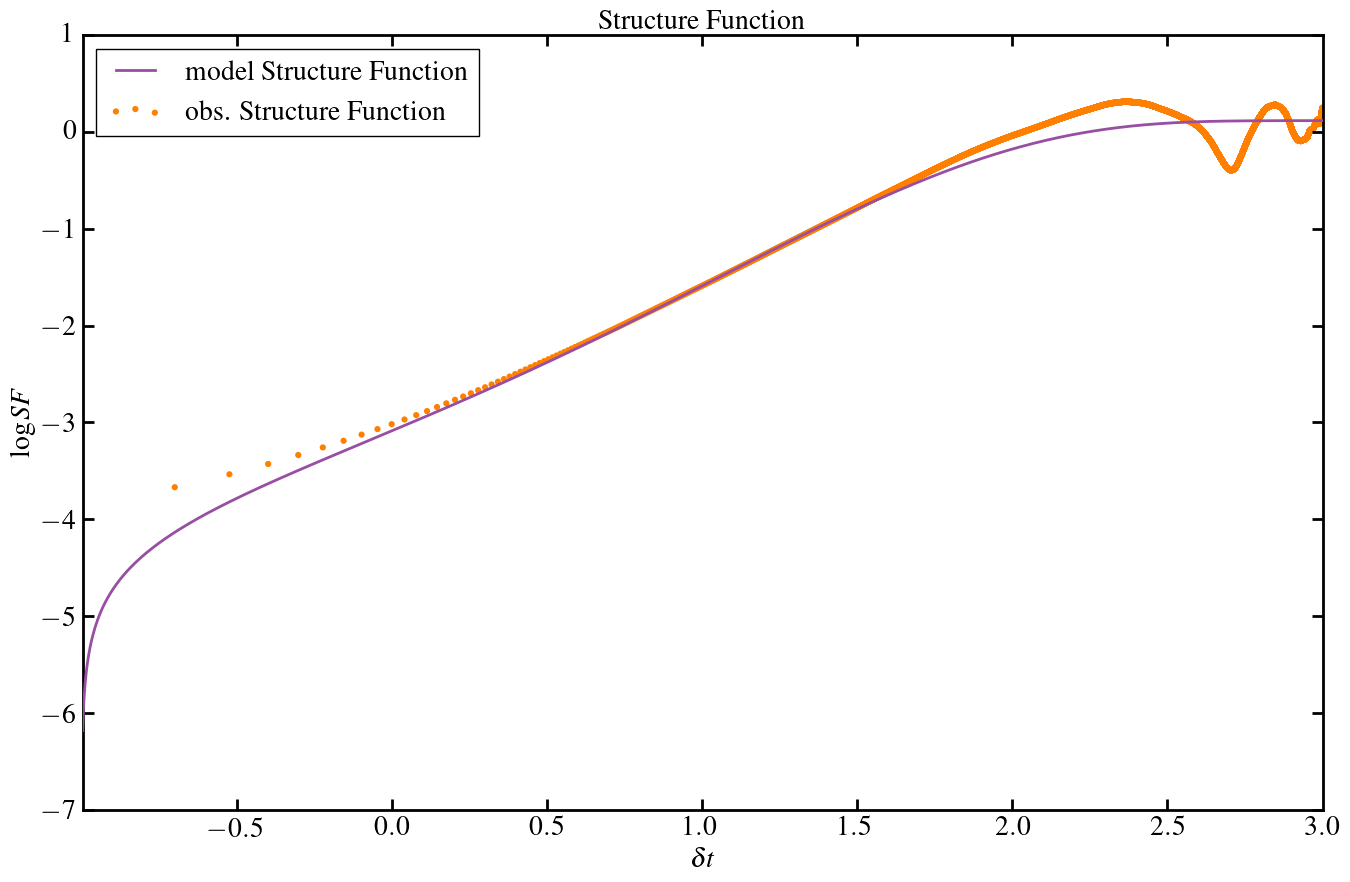

In [39]:
newTask.plotsf(LC = newLC, doShow = False)

Finally, we can smooth this light curve using the `smooth` function in `newTask`.

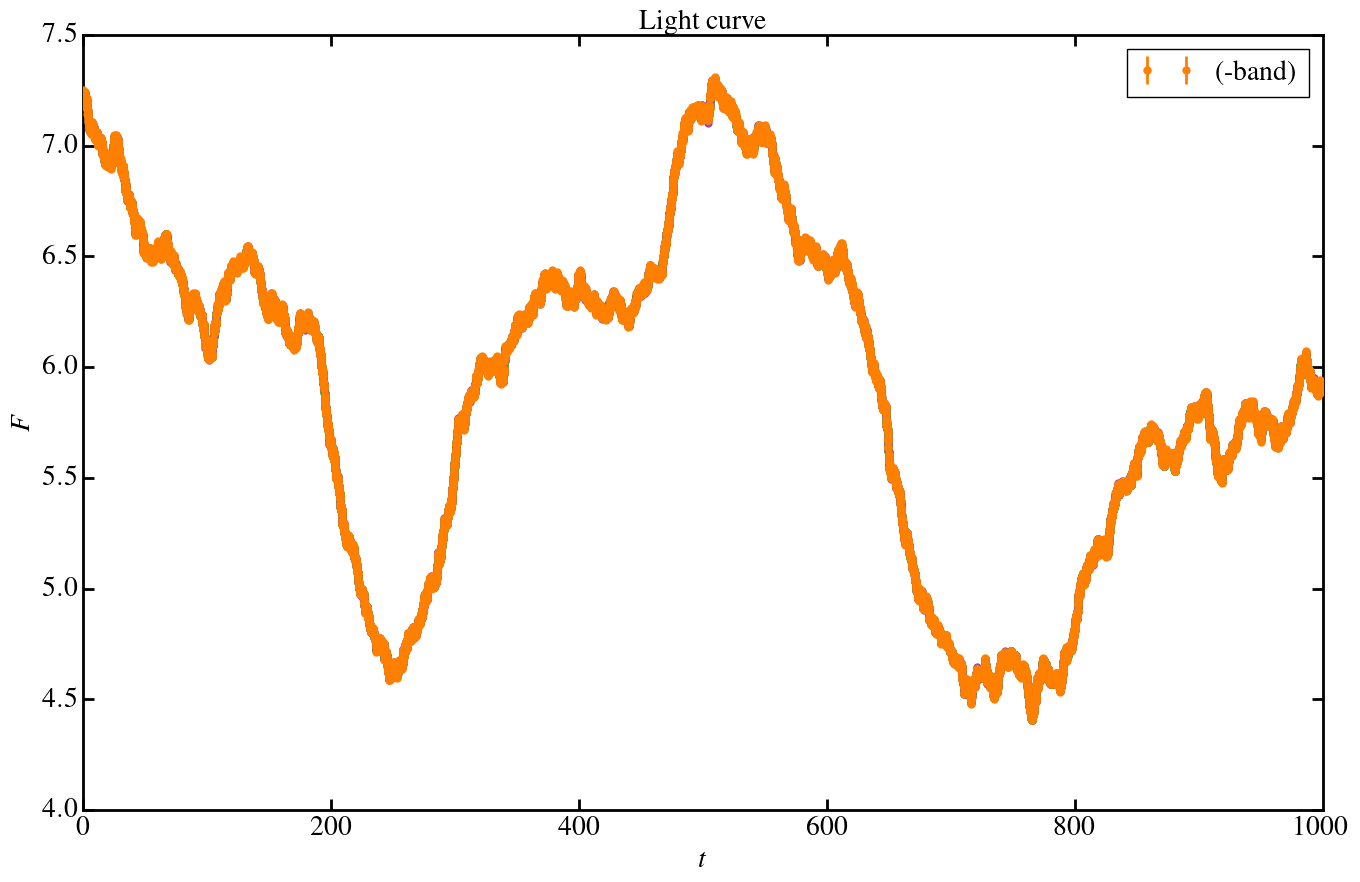

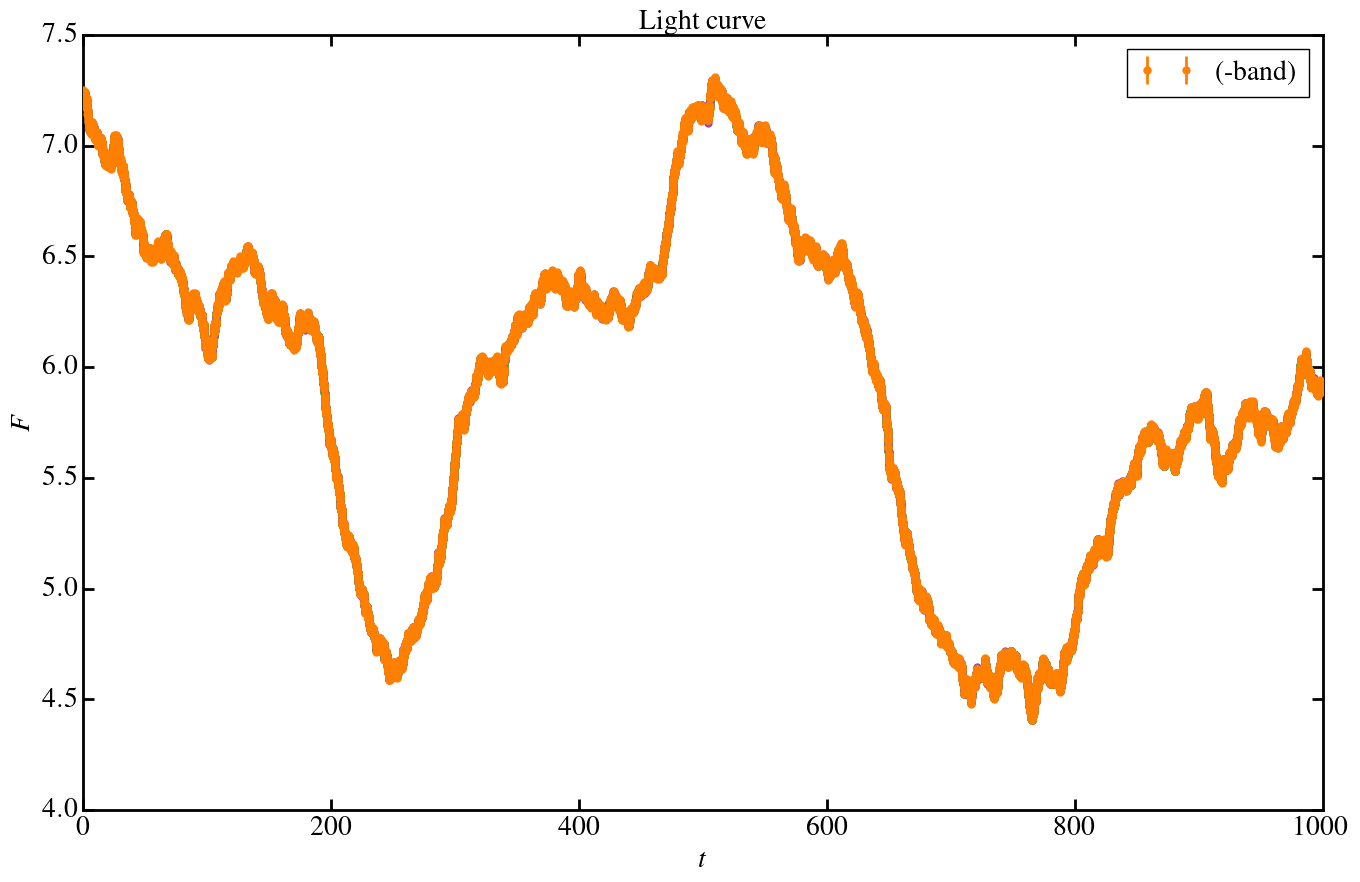

In [40]:
newTask.smooth(newLC)
newLC.plot()

We will illustrate the whole process for the `sdssLC` light curves below...

# # `sdssLC`s, `k2LC`s, and `crtsLC`s 

Kālī ships with three survey specific `lc` sub-classes for users to play with. Recall the point of custom light curve classes: different surveys make light curve data available in different ways and sometimes the data may need further pre-processing before it is suitable for scientific usage. Having custom `lc` sub-classes abstracts the process of getting a light curve for the user. For example, SDSS Stripe 82 light curves are available from a SQL database. The problem is that getting this data requires one to learn the SDSS SkyServer schema and perhaps learn a little SQL. Writing a query to grab the photometry of a single object across multiple SDSS runs is not hard but is non-trivial. More importantly,  `Ivezić et al. 2007 (Astronomical Journal, 134, 973)` provide an enhanced calibration of the Stripe 82 data. The `sdssLC` class is designed to make SDSS Stripe 82 quasar light curves re-calibrated using the Ivezić method easy to get ands use. Note that while only quasar light curvers are available at the moment, in principle there is no reason why light curves for any other class of objects (or even all objects in Stripe 82) can't be made avaialble via this class. Interested parties should contact either Vishal (vishal.kasliwal@gmail.com), or Jack (jobrien585@gmail.com).

How do these classes work? All light curve classes inherit from the base abstract `lc` class. The class constructor for `lc` does two things - uses the derived-class's `read` method to perform custom functionality, and then does some standard boilerplate work to finish constructing the `lc` object. When the constructor calls the `read` method of the derived class, it expects this `read` method to set `self.numCadences` (int), `self.t` (numpy array with `dtype=float64` wrapped in `np.require(self.t, requirements=['F', 'A', 'W', 'O', 'E'])`, `self.x` (also a numpy array `dtype=float64` wrapped in the `np.require` above), `self.y` (also a numpy array `dtype=float64` wrapped in the `np.require` above), `self.yerr` (also a numpy array `dtype=float64` wrapped in the `np.require` above), & `self.mask` (also a numpy array `dtype=float64` wrapped in the `np.require` above), `self.name` (string), `self.band` (string), `self.path` (string that must point at a path reachable on the user's system), `self.xunit` (string with appropriate usage of latex), and `self.yunit` (string with appropriate usage of latex). Once these attributes have been set, the derived-class `read` method returns control to the abstract base `lc` class' constructor which finishes constructing the ligfht curve object by performing some boiler-plate operations. Users who wish to write their own survey-specific `lc` classes should look at the existing `k2,py`, `s82.py`, & `crts.py` files for sample implentations. The `survey.py` template can be used to start writing a survey specific class. Users implementing a custom `lc` class are encoraged to make their work public by adding to the existing package (contact either Vishal Kasliwal or Jack O'Brien for details) and will be acknowledged as contributors. Survey specific classes can re-define functions inherited from the base `lc` class such as the `plot` functions (look at `s82.py` for examples).

How does one use the existing `lc` classes. Here are some examples. More examples can be found in the `examples` and `tests` folders.
To see the K2 light curve of OJ 287 (observed over K2 Campaign 5), set the environment variable `K2DATADIR` to point somewhere convenient and then do

/home/vish/code/kali/python/kali/k2.py:64: UserWarning: Could not fetch http://archive.stsci.edu/missions/hlsp/k2varcat/c05/211900000/91000/hlsp_k2varcat_k2_lightcurve_211991001-c05_kepler_v2_llc.fits
  warnings.warn('Could not fetch %s'%(fullURL), UserWarning)


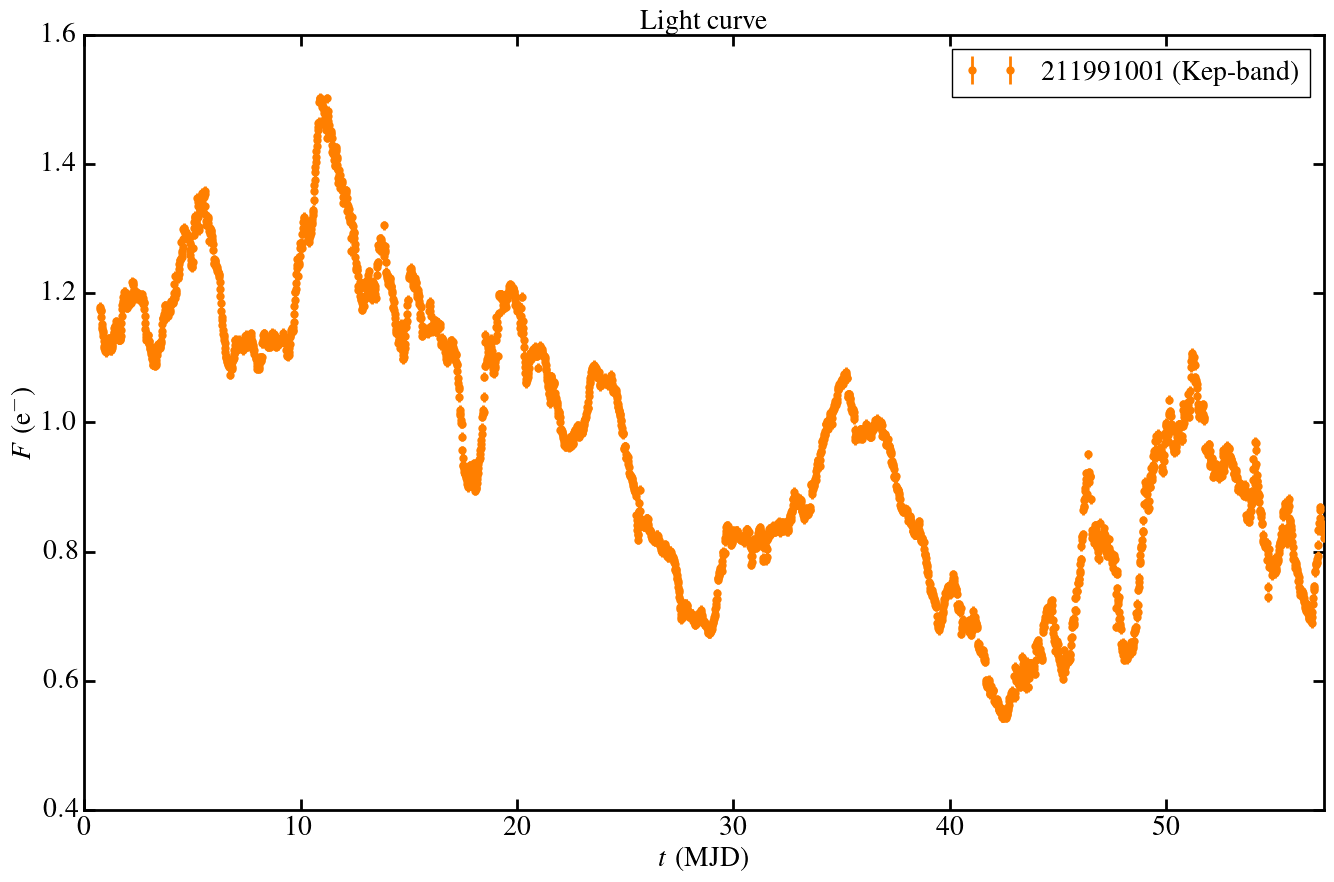

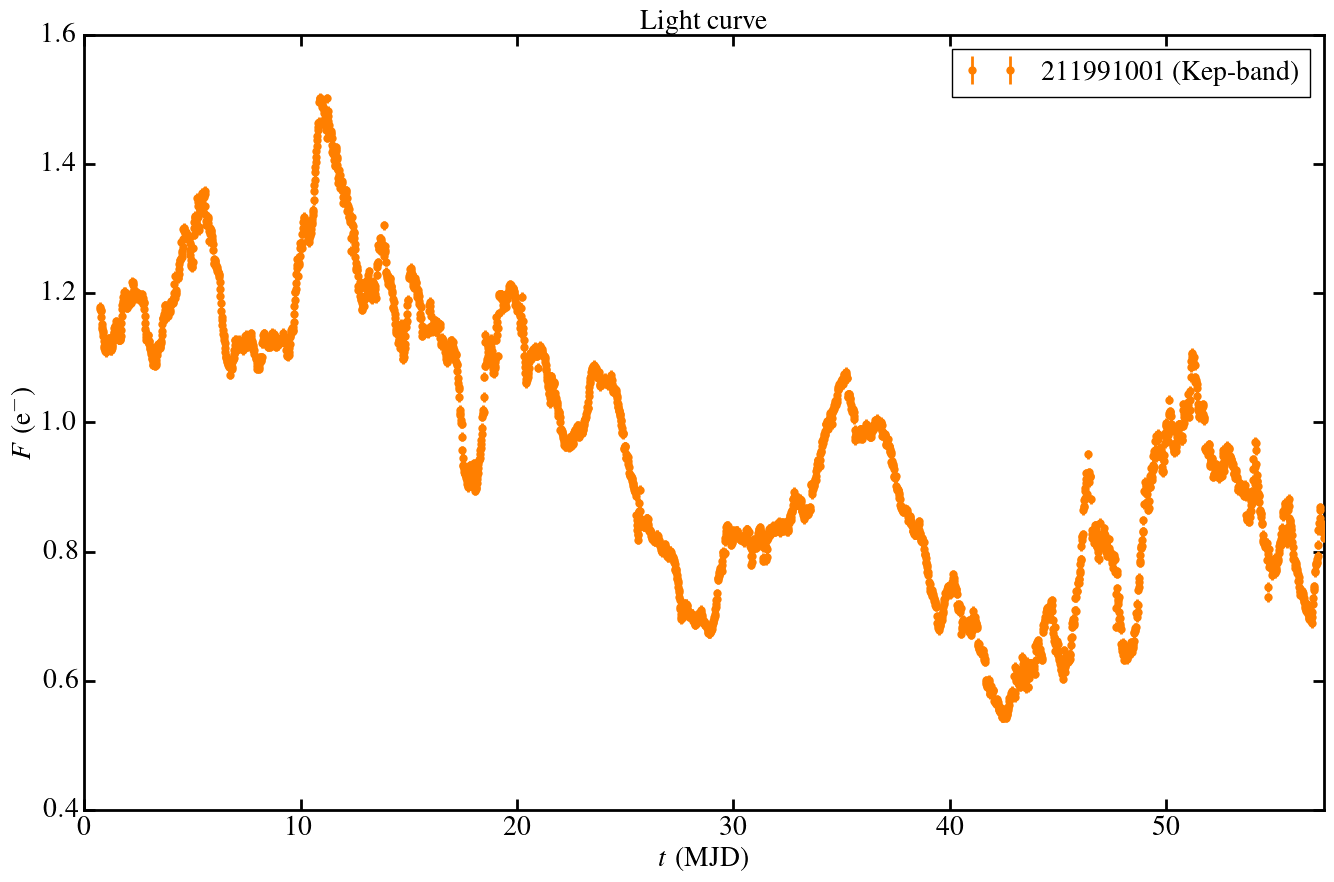

In [42]:
import kali.k2
OJ287 = kali.k2.k2LC(name = '211991001', band = 'Kep', campaign = 'c05', processing = 'vj', z = 0.3056)
OJ287.plot()

The SDSS Stripe 82 `sdssLC` class on the other hand uses `ZeroMQ` to query one of 2 servers that has the Stripe 82 quasars stored in a database. This approach is chosen instead accessing the data directly from CASJOBS because we calibrate the data further using S82 standard stars as described in `Ivezić et al. 2007 (Astronomical Journal, 134, 973)' (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/0703157)`. First, lets pull up a random SDSS light curve. After setting the environment variable `S82DATADIR` to point somewhere convenient, we can pull a random light curve from the remote server as follows

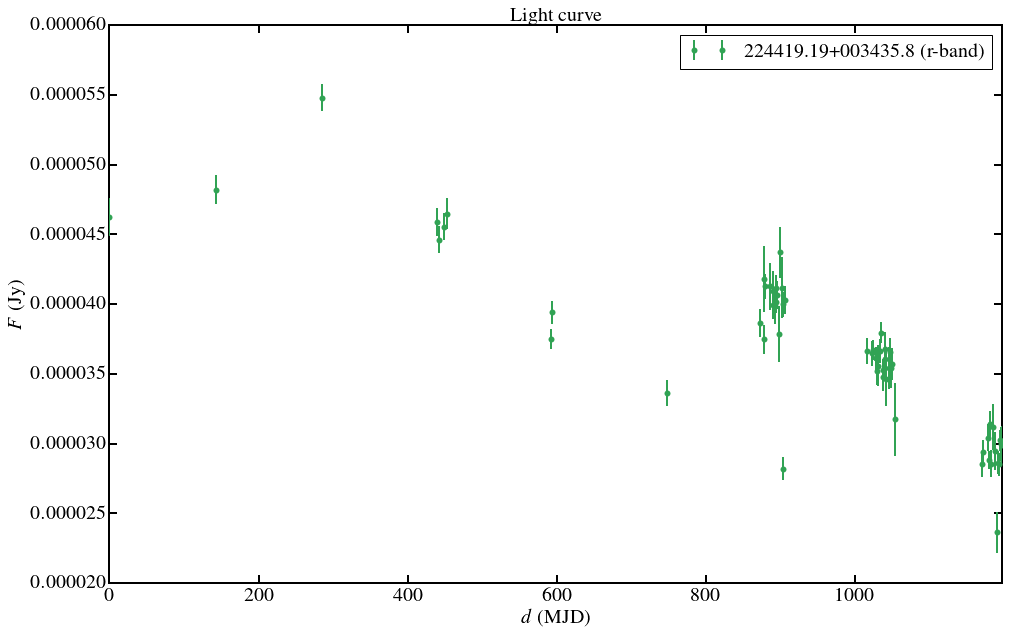

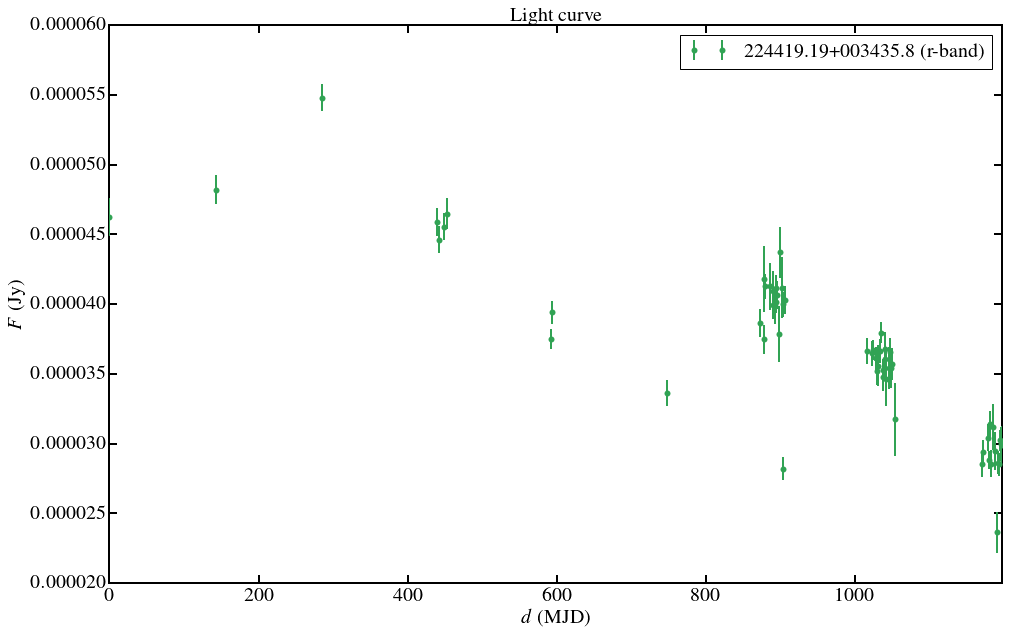

In [2]:
%matplotlib inline
import kali.s82
Jrandom = kali.s82.sdssLC(name = 'rand', band = 'r', path="." )
Jrandom.plot()

Notice that the `name` attribute of this object is simply the SDSS ID without the `J`.

In [3]:
Jrandom.name

'210705.29-000827.8'

Now lets pull up a specific SDSS light curve. Lets pull up the r-band SDSS Stripe 82 light curve of of the quasar `J230617.29+005814.1`. The `name` of this object is just `033806.19-001004.3`. We can get the light curve of thios object by doing the following

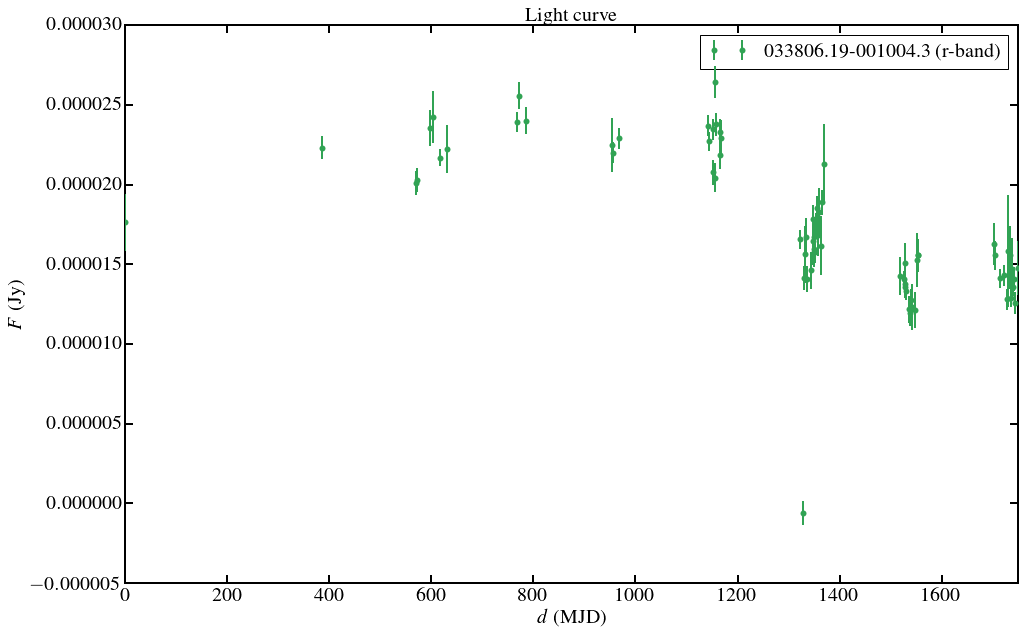

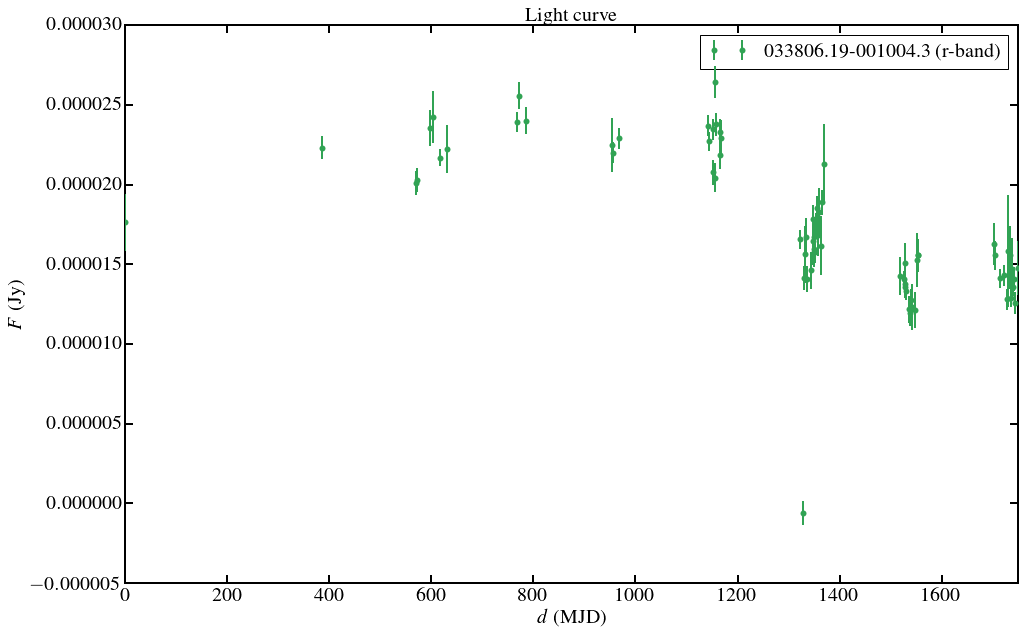

In [3]:
J03380619_0010043 = kali.s82.sdssLC(name = '033806.19-001004.3', band = 'r', path='.' )
J03380619_0010043.plot()

Now lets fit this light curve with a second order CARMA model. First lets create a fresh task object

In [4]:
import kali.carma
sdssAnalysisTask = kali.carma.CARMATask(2, 1)
result = sdssAnalysisTask.fit(J03380619_0010043)

Now that we have fit the light curve to a second order CARMA model, we can print out the best fit model parameters & look at a triangle plot of the CARMA parameters (in timescales) as follows

[  1.00197778e+00   2.65253505e-03   3.07054162e-07   3.32676492e-06]
[  1.00067701e+00   3.76742787e+02   1.08344564e+01   4.82283981e-06]


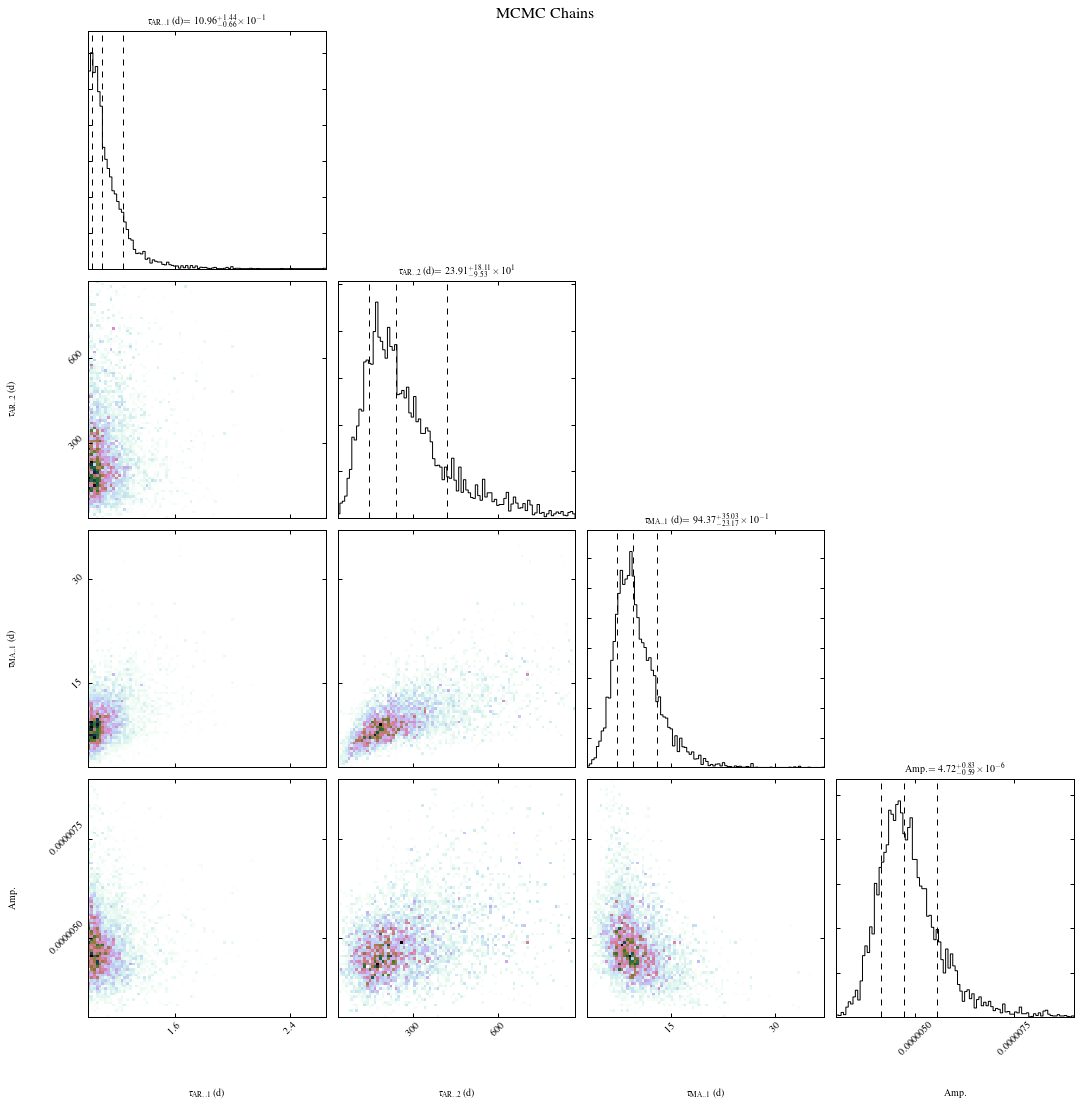

In [5]:
print sdssAnalysisTask.bestTheta
print sdssAnalysisTask.bestTau
tauTriangle = sdssAnalysisTask.plottriangle()

Looking at the best fit tau and the triangle plot, we see that the maximum likelihood estimate of tau suggests that this light curve has a built in 377.0 C-AR day timescale while the median timescale is closer to 239.6 day. We can smooth the light curve using the best-fit CARMA model as follows

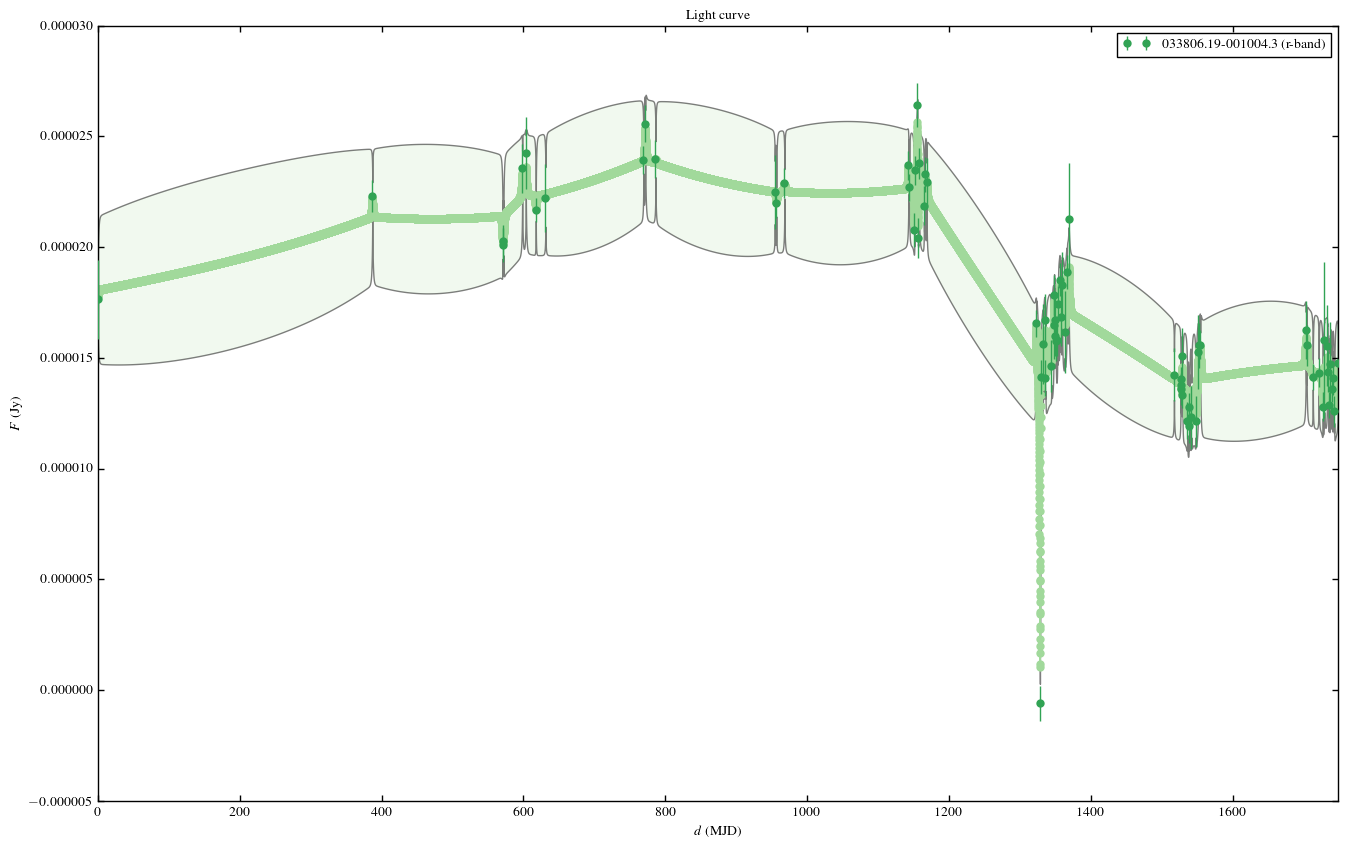

In [38]:
res = sdssAnalysisTask.set(J03380619_0010043.dt, sdssAnalysisTask.bestTheta)
res = sdssAnalysisTask.smooth(J03380619_0010043)
J03380619_0010043.plot()

How does our fit look as far as the structure function goes?

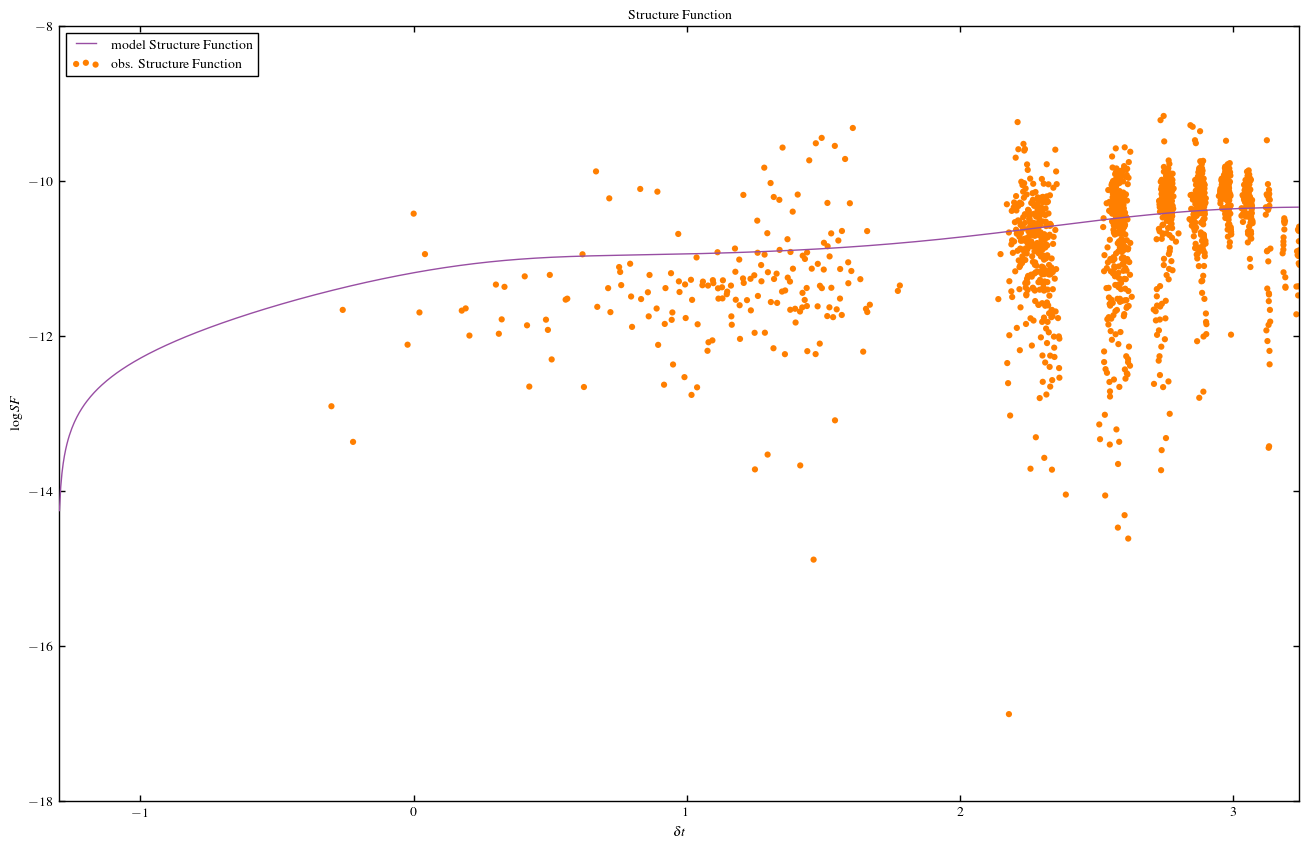

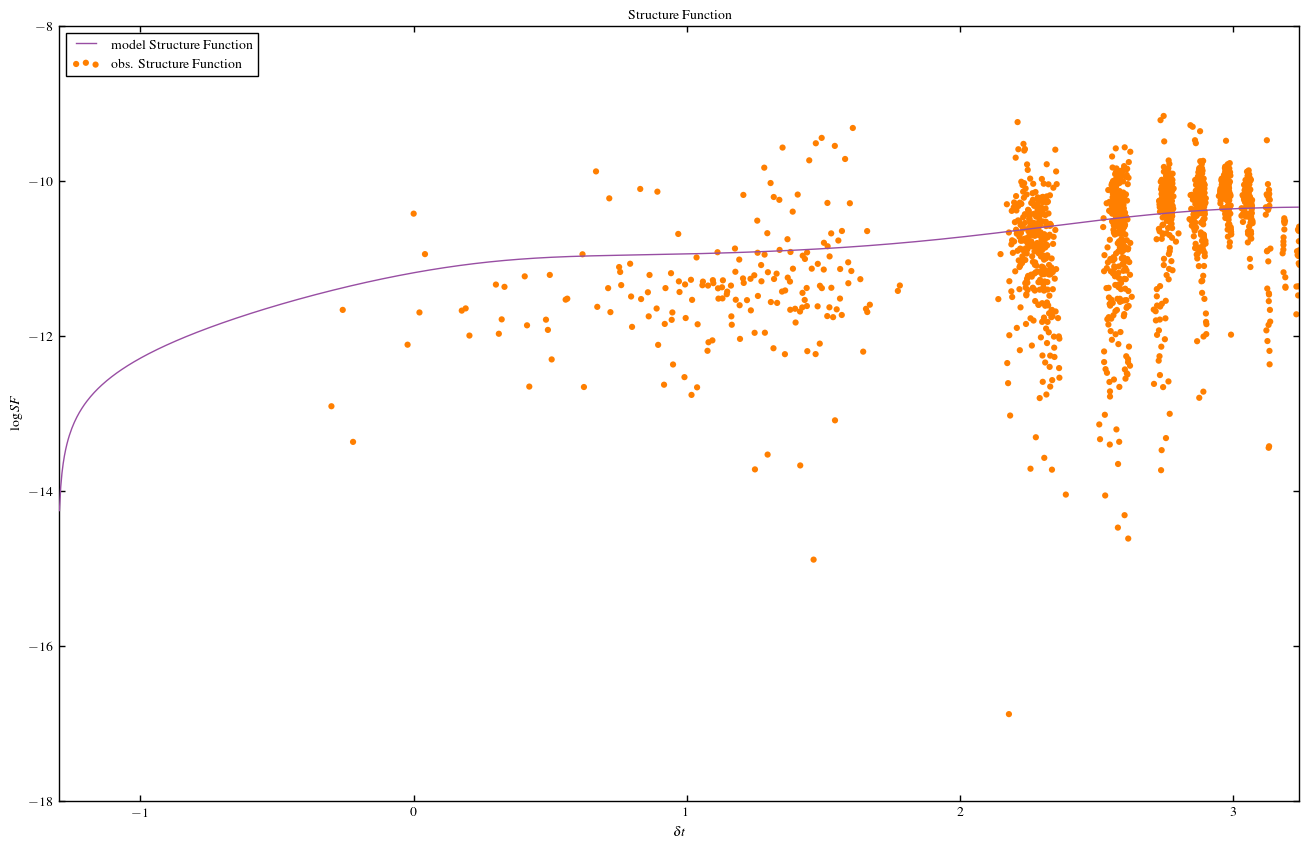

In [39]:
sdssAnalysisTask.plotsf(LC=J03380619_0010043)